# Clickabit detection using informativeness measures

## Packages

In [68]:
import warnings
import unicodedata
import string 

import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
import textstat
from lexical_diversity import lex_div

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import math
import re
from tqdm import tqdm

from textblob import TextBlob
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

from tabulate import tabulate
from statsmodels.stats.weightstats import ttest_ind

In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /home/tymek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [69]:
MODEL = Word2Vec.load("../pretrained_models/custom_word2vec.model")
STOP_WORDS = stopwords.words("english")

In [ ]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
pd.set_option('display.max_colwidth', 50)

## Preprocessing

In [70]:
raw_data = pd.read_csv("../data/cc_dataset_balanced.csv")
huge_data_raw = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [71]:
# drop NA
raw_data = raw_data.drop(raw_data[raw_data['body'].isna()].index)
raw_data = raw_data.drop_duplicates(['title'])
full_data = raw_data.copy()

In [72]:
# clean escape characters
full_data['body'] = full_data['body'].apply(lambda x: unicodedata.normalize('NFKC', x))
full_data['title'] = full_data['title'].apply(lambda x: unicodedata.normalize('NFKC', x))

huge_data_raw['title'] = huge_data_raw['title'].apply(lambda x: unicodedata.normalize('NFKC', x))

In [73]:
# universal split across notebooks
h_train, h_test = train_test_split(
    huge_data_raw[["title", "clickbait", "set"]], 
    test_size=0.2, 
    random_state=42
)

CC dataset will be used to analyze body and compare models w/ and w/o body. It is loaded seperately and we need to ensure that in the train data there is no test data from huge_dataset.

In [74]:
# get huge data only for clickbait challenge dataset
test_3 = h_test[h_test['set']==3].copy()
test_3['title'] = test_3['title'].apply(lambda x: unicodedata.normalize('NFKC', x))

In [75]:
# this will be used only for testing
part_test_data = pd.merge(left=test_3, right=full_data, on=['title', 'clickbait'], how='inner')[['title', 'body', 'clickbait']]

# this can be used for both training and testing
test_merged = pd.merge(left=test_3, right=full_data, on=['title'], how='right') 
not_test_data = test_merged[test_merged['clickbait_x'].isna()][['title', 'body', 'clickbait_y']].rename({'clickbait_y': 'clickbait'}, axis=1)

assert len(part_test_data) + len(not_test_data) <= len(test_merged)

In [76]:
print('test:', part_test_data['clickbait'].value_counts(), "\n")
print('train:', not_test_data['clickbait'].value_counts())

test: clickbait
1    778
0    437
Name: count, dtype: int64 

train: clickbait
0    8873
1    8514
Name: count, dtype: int64


In [77]:
train_rows_count = 7500

transfer_0 = not_test_data[not_test_data['clickbait']==0].shape[0] - train_rows_count
transfer_1 = not_test_data[not_test_data['clickbait']==1].shape[0] - train_rows_count

transfer_rows_0 = not_test_data[not_test_data['clickbait']==0].sample(n=transfer_0, random_state=42)
transfer_rows_1 = not_test_data[not_test_data['clickbait']==1].sample(n=transfer_1, random_state=42)

cc_test_data = pd.concat([part_test_data, transfer_rows_0, transfer_rows_1])
cc_data = not_test_data.drop(transfer_rows_0.index).drop(transfer_rows_1.index)

In [78]:
cc_data.to_csv("../data/inf_measures_data/data.csv", index=False)
cc_test_data.to_csv("../data/inf_measures_data/test_data.csv", index=False)

In [79]:
# cc datasets for body analysis
cc_data = pd.read_csv("../data/inf_measures_data/data.csv")
cc_test_data = pd.read_csv("../data/inf_measures_data/test_data.csv")

In [80]:
# whole dataset for title analysis
data = h_train
test_data = h_test

## EDA

In [95]:
eda_df = data.copy()

### Punctuation

In [96]:
def count_punkt(text, punkt):
    return sum([1 for char in text if char == punkt])

for punkt in string.punctuation:
    eda_df[f'{punkt}_count'] = eda_df['title'].apply(lambda x: count_punkt(x, punkt))

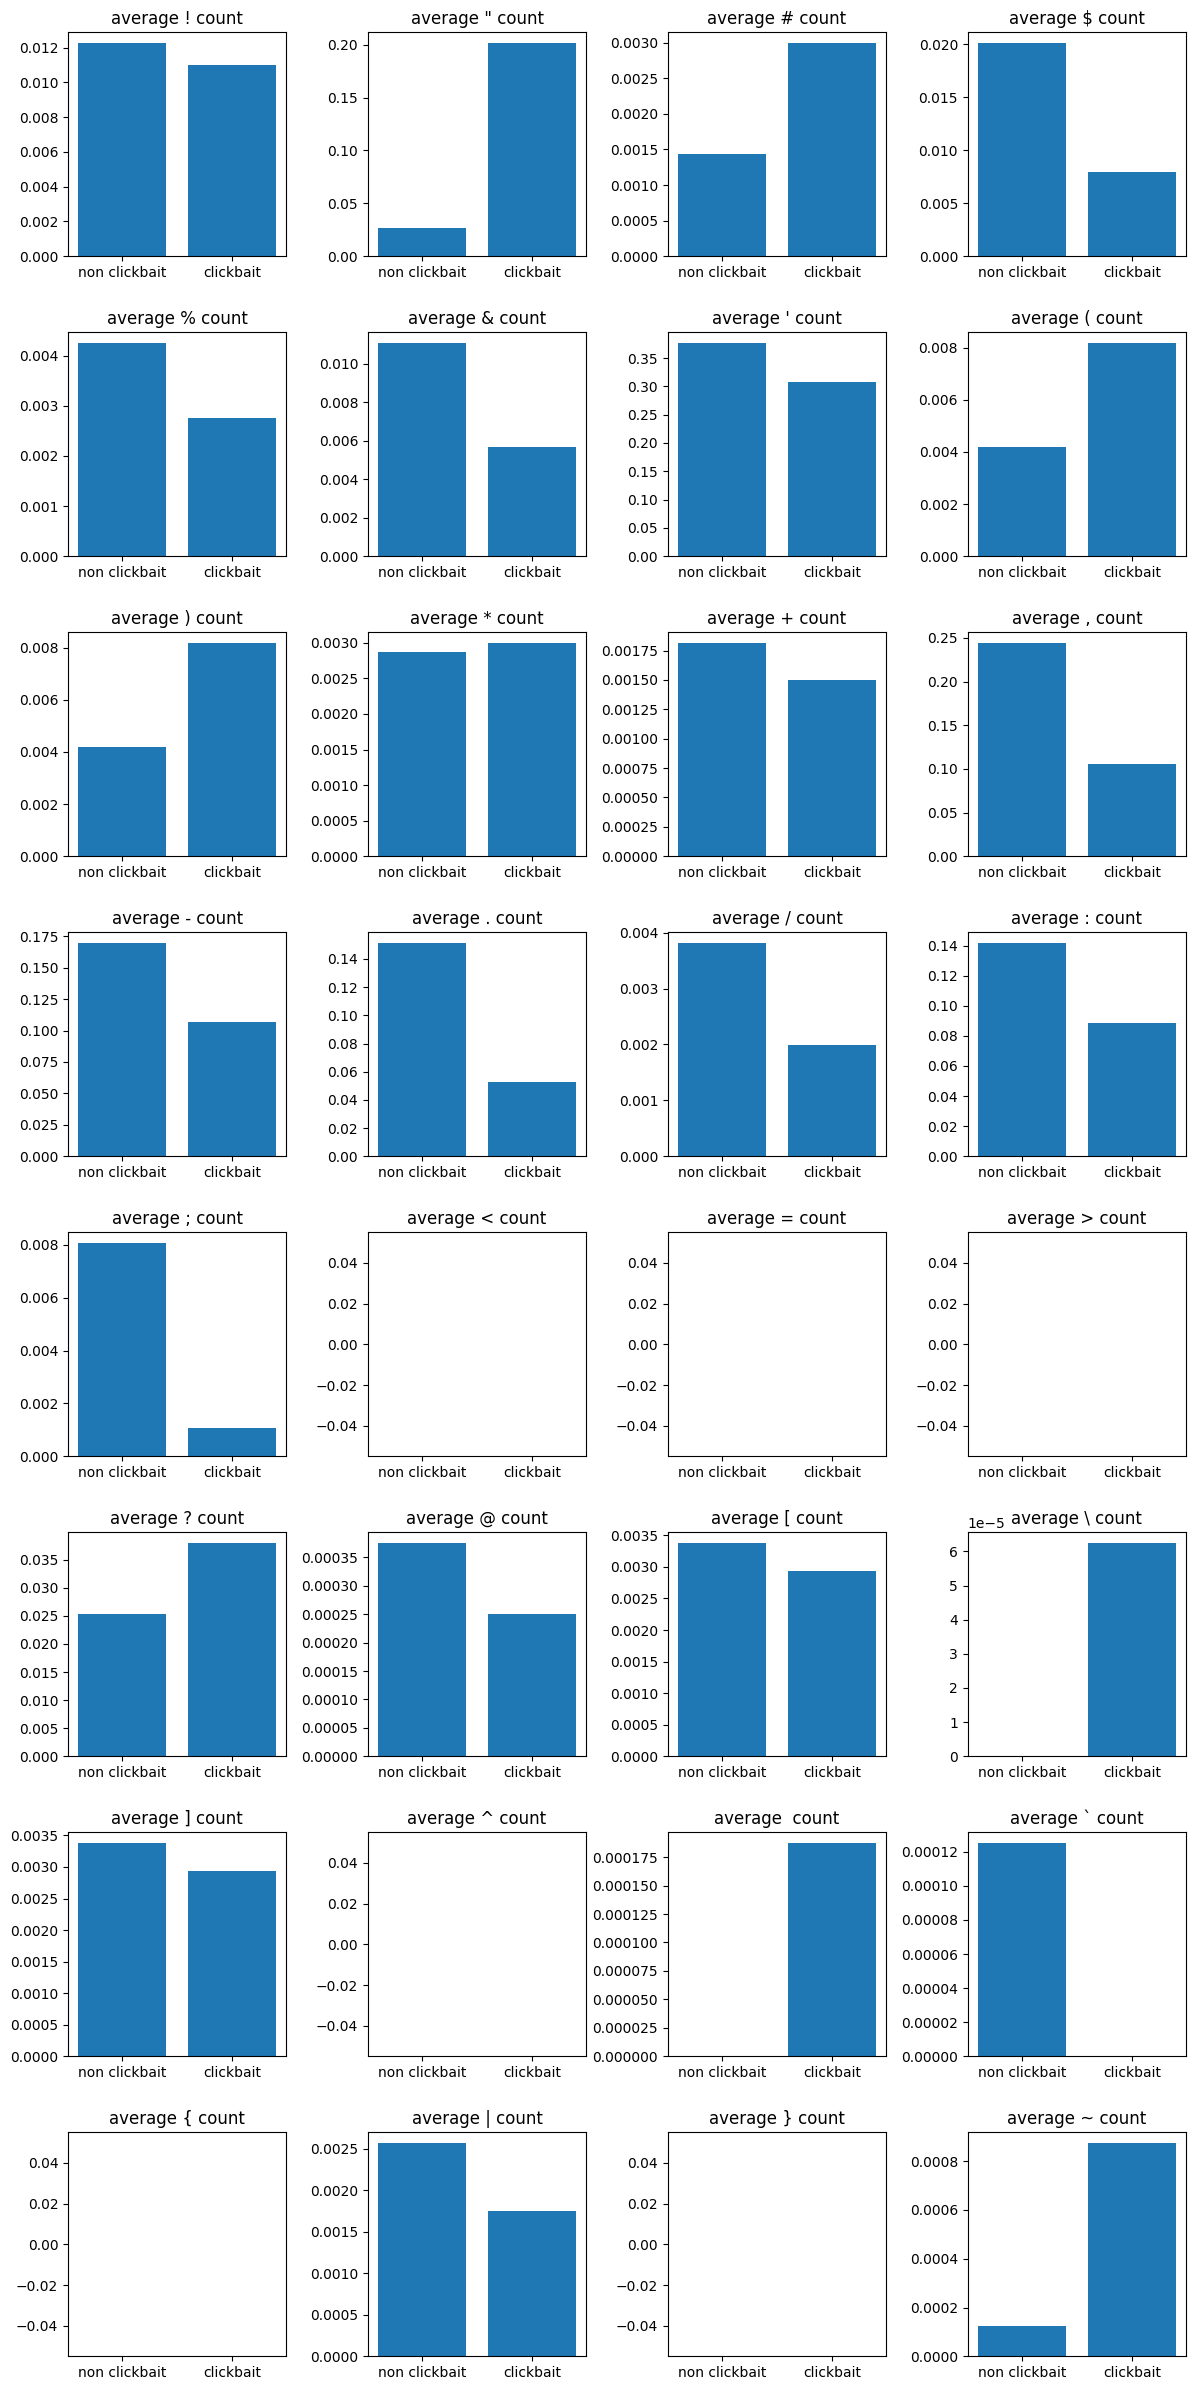

In [97]:
plt.figure(figsize=(12,24))
columns = eda_df.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(8, 4, i+1)
    n_mean = eda_df[eda_df['clickbait'] == 0][col].mean()
    c_mean = eda_df[eda_df['clickbait'] == 1][col].mean()
    plt.bar(['non clickbait', 'clickbait'], height=[n_mean, c_mean])
    plt.title(f"average {col.split('_')[0]} {col.split('_')[-1]}")
plt.tight_layout()
plt.show()

Based on those features we plan to build two measures - clickbait punctuation and non clickbait punctuation. We are taking into account only punctuation with average count over 0.001. <br>
<br>
clickbaits: !"#()? <br>
non clickbaits: $%&,.;:-/

### sth

## Embedding model

Training model for word embedding for similarity scores

In [98]:
def preprocess_text(text):
    """ preprocess data for embedding model training """
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return tokens

In [99]:
df = cc_data.copy()

In [ ]:
df['body_len'] = df['body'].apply(lambda x: len(x))
th = np.percentile(df['body_len'], 90)
df = df[df['body_len'] < th]

In [ ]:
df["title_tokens"] = df["title"].apply(preprocess_text)
df["body_tokens"] = df["body"].apply(preprocess_text)
df["combined_tokens"] = df["title_tokens"] + df["body_tokens"]
sentences = df["combined_tokens"].tolist()

In [ ]:
model = Word2Vec(sentences, vector_size=100, min_count=1, workers=4)

In [ ]:
model.save("../pretrained_models/custom_word2vec.model")

## Metrics definition

Defining informativeness measures

In [100]:
""" helper functions """

def remove_punctuation(text):
    """ removes punctuation """
    return text.translate(str.maketrans('', '', string.punctuation))

def preprocess_text(text):
    """ preprocess data for embedding model training """
    if isinstance(text, list):
        text = ' '.join(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return tokens

def get_embedding(sentence):
    """ gets embeddings """
    word_embeddings = [MODEL.wv[word] for word in sentence if word in MODEL.wv]
    if not word_embeddings: 
        return np.zeros(MODEL.vector_size)
    sentence_embedding = np.mean(word_embeddings, axis=0)
    return sentence_embedding

In [104]:
def words_count(text):
    """ calculates number of words """
    return len(text.split())

def characters_count(text):
    """ calculates number of characters including whitespaces """
    return len(text.strip())

def avg_word_length(text):
    """ calculates average word length """
    return float(np.mean([len(word) for word in word_tokenize(remove_punctuation(text))]))

def common_words_ratio(text):
    """ percentage of stop words in text """
    words = word_tokenize(remove_punctuation(text.lower()))
    common_words = [word for word in words if word in STOP_WORDS]
    return len(common_words) / len(words)

def capital_letters_ratio(text):
    """ calculates capital letters ratio """
    return sum([char.isupper() for char in list(text)]) / len(text)

def capital_words_count(text):
    """ calculates capital words """
    return sum([1 for word in word_tokenize(text) if word.isupper() and len(word) > 1])

def punctuation_ratio(text):
    """ calculates punctuation ratio """
    return sum([1 for x in text if x in string.punctuation]) / len(text)

def clickbait_punctuation_count(text):
    """ counts clickbait related punctuation, only left brackets as otherwise they would be double calculated """
    punctuation = '!"#(?'
    return sum([1 for x in text if x in punctuation])

def nonclickbait_punctuation_count(text):
    """ counts non-clickbait related punctuation """
    punctuation = "$%&,.;:-/"
    return sum([1 for x in text if x in punctuation])

def numbers_count(text):
    """ calculates ratio of numbers (not digits) to words """
    text = remove_punctuation(text)
    return sum([x.isnumeric() for x in word_tokenize(text)])

def pronouns_count(text):
    """ pronouns usage """
    tagged = pos_tag(word_tokenize(text.lower()))
    return sum([1 for x in tagged if x[1] in ('PRP', 'PRP$', 'WP', 'WP$')])

def pronouns_2nd_person_count(text):
    """ 2nd person pronouns usage """
    second_person_pronouns = ["you", "your", "yours", "yourself", "yourselves"]
    return sum([1 for x in word_tokenize(text.lower()) if x in second_person_pronouns])

def superlatives_ratio(text):
    """ percentage of adjectives and adverbs which are in superlative form """
    tagged_words = pos_tag(word_tokenize(text.lower()))
    adj_adv_count = 0
    superlative_count = 0
    for _, tag in tagged_words:
        if tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'):
            adj_adv_count += 1
            if tag in ('JJS', 'RBS'):  # if superlative
                superlative_count += 1
    if adj_adv_count == 0:
        return 0
    return superlative_count / adj_adv_count

def speculatives_count(text):
    """ usage of speculative forms """
    speculative_words = {
        "might", "may", "could", "can", "perhaps", "possibly", "probably", "maybe",
        "seems", "appears", "suggests", "indicates", "likely", "unlikely", "assume"
    }
    return sum([1 for x in word_tokenize(text.lower()) if x in speculative_words])

def baiting_words_count(text):
    """ number of baiting words used """
    bait_words = {"sexy", "nudes", "OMG", "TWEETS", "VIDEO"}
    return sum([1 for x in word_tokenize(text) if x in bait_words])

def similarity_score(title, body):
    """ custom word2vec model embeddings and cosine similarity """
    title_embedding = get_embedding(word_tokenize(title.lower()))
    body_embedding = get_embedding(preprocess_text(word_tokenize(body.lower())))
    return (1 - cosine(title_embedding, body_embedding))

def polarity_score(text):
    """ polarity score """
    return TextBlob(text).sentiment.polarity

def subjectivity_score(text):
    """ subjectivity score """
    return TextBlob(text).sentiment.subjectivity

def type_token_ratio(text):
    """ lexical richness, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    unique_words = set(words)
    return len(unique_words) / len(words)

def corrected_type_token_ratio(text):
    """ lexical richness, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    unique_words = set(words)
    return len(unique_words) / np.sqrt(2 * len(words))

def maas_index(text):
    """ lexical diversity index, the lower the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    n = len(words)
    if n == 1:
        return 0
    t = len(set(words))
    return (math.log(n) - math.log(t)) / (math.log(n) ** 2)

def hdd_metric(text):
    """ hypergeometric distribution D, lexical diversity, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    if len(words) < 42:
        message = f"The text is {len(words)} words long. HD-D metric is not defined for texts with less than 42 tokens."
        warnings.warn(message, UserWarning)
    return lex_div.hdd(words)

def flesch_reading_ease_score(text):
    """ difficulty of the text, if its easy to read or not, the higher the easier
    
    Formula:
    206.835 - 1.015 * (total words / total sentences) - 84.6 (total syllables / total words)

    Scores:
    -90.00  	Very easy to read. Easily understood by an average 11-year-old student.
    90.0-80.0	Easy to read. Conversational English for consumers.
    80.0-70.0	Fairly easy to read.
    70.0-60.0	Plain English. Easily understood by 13- to 15-year-old students.
    60.0-50.0	Fairly difficult to read.
    50.0-30.0	Difficult to read.
    30.0-10.0	Very difficult to read. Best understood by university graduates.
    10.0-   	Extremely difficult to read. Best understood by university graduates.
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_reading_ease(text)

def flesch_kincaid_grade_level(text):
    """ difficulty of the text, US grade level needed to understand the text quite easily, the higher the harder

    Formula:
    0.39 * (total words / total sentences) + 11.8(total syllables / total words) - 15.59

    can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_kincaid_grade(text)

def automated_readability_index(text):
    """ difficulty of the text, US grade level necessary to comprehend the text, the higher the harder

    Formula:
    4.71 * (characters / words) + 0.5 (words / sentences) - 21.43

    Scores:
    score | age | grade level
    1	5-6	    Kindergarten
    2	6-7	    First Grade
    3	7-8	    Second Grade
    4	8-9	    Third Grade
    5	9-10	Fourth Grade
    6	10-11	Fifth Grade
    7	11-12	Sixth Grade
    8	12-13	Seventh Grade
    9	13-14	Eighth Grade
    10	14-15	Ninth Grade
    11	15-16	Tenth Grade
    12	16-17	Eleventh Grade
    13	17-18	Twelfth Grade
    14	18-22	College student
    source: https://en.wikipedia.org/wiki/Automated_readability_index
    """
    return textstat.automated_readability_index(text)


In [105]:
metrics_functions = {
    "n_words": words_count,
    "n_characters": characters_count,
    "mean_word_length": avg_word_length,
    "cw_percentage": common_words_ratio,
    "capitals_ratio": capital_letters_ratio,
    "capitals_count":capital_words_count,
    "punct": punctuation_ratio,
    "bait_punct": clickbait_punctuation_count,
    "nonbait_punct": nonclickbait_punctuation_count,
    "numbers": numbers_count,
    "pronouns": pronouns_count,
    "2nd_pronouns": pronouns_2nd_person_count,
    "superlatives": superlatives_ratio,
    "speculatives": speculatives_count,
    "bait_words": baiting_words_count,
    "similarity": similarity_score,
    "polarity": polarity_score,
    "subjectivity": subjectivity_score,
    "ttr": type_token_ratio,
    "cttr": corrected_type_token_ratio,
    "mass_index": maas_index,
    "hdd": hdd_metric,
    "fres": flesch_reading_ease_score,
    "fkgl": flesch_kincaid_grade_level,
    "ari": automated_readability_index
}

In [108]:
""" test """

sample_text = "These 12 Most Impossible Pet Rescure Stories Will Melt Your Heart! (VIDEO)"

sample_body = """
Recently, we asked the BuzzFeed Community to tell us their pet adoption stories. Here are some of the sweetest, heartwarming, and most ~meant-to-be~ submissions:
1. From stray to service dog
"My younger brother — who lives with autism and Type 1 diabetes — has needed a service dog for a while now. So when my family met Ellie, a sweet, attentive rescue from Mexico, we instantly knew she was the right dog for my brother.
Right now, someone has to wake up every 2-3 hours at night to check my brother's blood sugar, and we have to constantly watch to make sure he doesn’t eat something without telling us. Once Ellie graduates her training, we'll all be able to sleep through the night and loosen the reigns on my brother during the day. It’s impossible to express how thankful we are that we found Ellie."
-maritnifa68
2. Brew-ser
"I was at a beer fest when I overheard this woman say, 'I’m just going to leave this dog on the street. I can’t take it anymore.' I had drank just enough beer to turn around and say, 'I’ll take your dog!'
12 years later, and here's my handsome boy, appropriately named Brew-ser!"
—megank29
"""

for key, f in metrics_functions.items():
    if key == 'similarity':
        # continue
        print(f"{key}: {f(sample_text, sample_body)}")
        continue
    print(f"{key}: {f(sample_text)}")

n_words: 12
n_characters: 74
mean_word_length: 5.0
cw_percentage: 0.3333333333333333
capitals_ratio: 0.20270270270270271
capitals_count: 1
punct: 0.04054054054054054
bait_punct: 2
nonbait_punct: 0
numbers: 1
pronouns: 1
2nd_pronouns: 1
superlatives: 0.3333333333333333
speculatives: 0
bait_words: 1
similarity: 0.7089114087129182
polarity: -0.16666666666666663
subjectivity: 0.75
ttr: 1.0
cttr: 2.4494897427831783
mass_index: 0.0
hdd: 0.0
fres: 76.22
fkgl: 5.6
ari: 9.3


/tmp/ipykernel_1266/3498089116.py:123: UserWarning: The text is 12 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)


## EDA & models

### Title analysis

#### Preprocessing

In [109]:
data_metrics = data.copy()

In [110]:
# apply metrics
for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        data_metrics[name] = data_metrics['title'].apply(function)

for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        test_data[name] = test_data['title'].apply(function)

100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


array([[<Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>,
        <Axes: title={'center': 'mean_word_length'}>,
        <Axes: title={'center': 'cw_percentage'}>,
        <Axes: title={'center': 'capitals_ratio'}>],
       [<Axes: title={'center': 'capitals_count'}>,
        <Axes: title={'center': 'punct'}>,
        <Axes: title={'center': 'bait_punct'}>,
        <Axes: title={'center': 'nonbait_punct'}>,
        <Axes: title={'center': 'numbers'}>],
       [<Axes: title={'center': 'pronouns'}>,
        <Axes: title={'center': '2nd_pronouns'}>,
        <Axes: title={'center': 'superlatives'}>,
        <Axes: title={'center': 'speculatives'}>,
        <Axes: title={'center': 'bait_words'}>],
       [<Axes: title={'center': 'polarity'}>,
        <Axes: title={'center': 'subjectivity'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>,
        <Axes: title={'center': 'mass_index'}>],
       [<Axes: title={'center': 'f

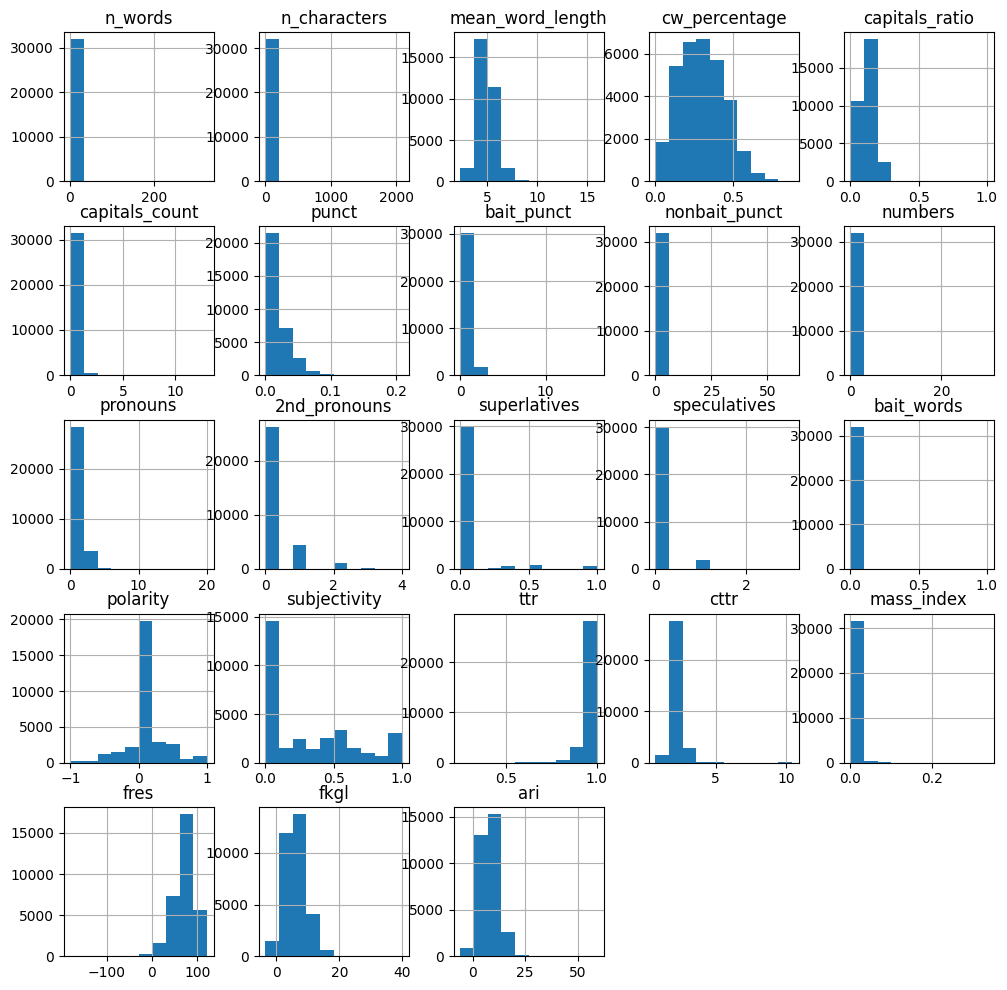

In [113]:
# check histograms
data_metrics.drop(['title', 'clickbait', 'set'], axis=1).hist(figsize=(12,12))

Histograms for n_words and n_characters look bad. There are some outliers, possibly because of flaws in data scraping, for example:

In [114]:
# example of problematic title
long_titles = data_metrics[data_metrics['n_words'] > 100]
long_titles['title'].iloc[2]

"Sections Shows Live Yahoo!-ABC News Network | © 2017 ABC News Internet Ventures. All rights reserved. ABC News Texas High School Student Killed on Drive to Graduation Ceremony High School Student Killed on Drive to Graduation Ceremony Trump was talking about general surveillance in wiretapping claims, Spicer says GOP congressman defends racially charged tweet against critics States seeking Trump travel ban block want new hearing Verizon sought $925 million penalty for Yahoo's lax security Abrupt dismissals leave US attorneys scrambling Shots fired at Ferguson protest sparked by new documentary Carlos the Jackal regrets not killing 'people I should have' Photography project captures 'first hello' between parents and newborns Pregnant woman rewards man who offered his seat with a custom trophy Mom reunited with lost family video found at Goodwill Villanova's 2016 March Madness win recreated with Legos Disinfecting agent turns Canada city's water bright pink Friar dog adopted by monaster

In [117]:
# mean
print(f"mean number of words: {round(np.mean(data_metrics['n_words']), 1)}\n")
# percentiles
q_percentiles = [90, 99, 99.5, 99.7, 99.9]
percentiles = np.percentile(data_metrics['n_words'], q_percentiles)
print(f"Percentiles:\nq: {q_percentiles}\n{percentiles}")

mean number of words: 10.7

Percentiles:
q: [90, 99, 99.5, 99.7, 99.9]
[ 15.     24.     29.     32.    110.007]


In [121]:
# clickbait / non-clickbait ratio
long_titles = data_metrics[data_metrics['n_words'] > 40]
print("", long_titles['clickbait'].value_counts())

 clickbait
0    30
1    16
Name: count, dtype: int64


Looking at the percentiles we can safely delete all titles longer than 40 words, also the ratio of target variable won't be disturbed

In [122]:
# dropping outliers
shortened_metrics = data_metrics[data_metrics['n_words'] <= 40].copy()

array([[<Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>]], dtype=object)

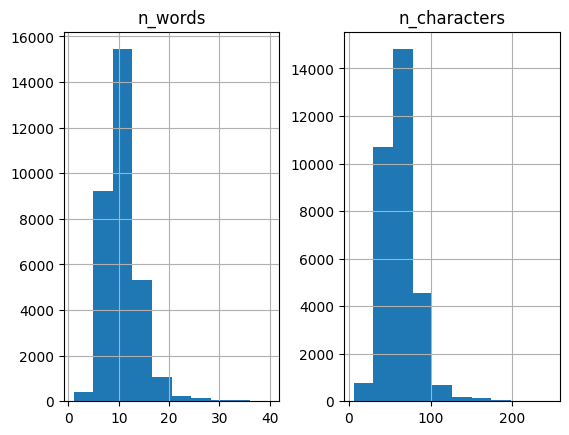

In [123]:
# check histograms again
shortened_metrics[['n_words', 'n_characters']].hist()

In [140]:
final_data = shortened_metrics

In [125]:
# lets check outliers for articles the same way, only for cc dataset

In [126]:
# apply metrics
for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        cc_data[name] = cc_data['title'].apply(function)

for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        cc_test_data[name] = cc_test_data['title'].apply(function)

100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


In [127]:
# apply metrics
name = 'n_words'
function = metrics_functions[name]
cc_data[f"body_{name}"] = cc_data['body'].apply(function)

<Axes: >

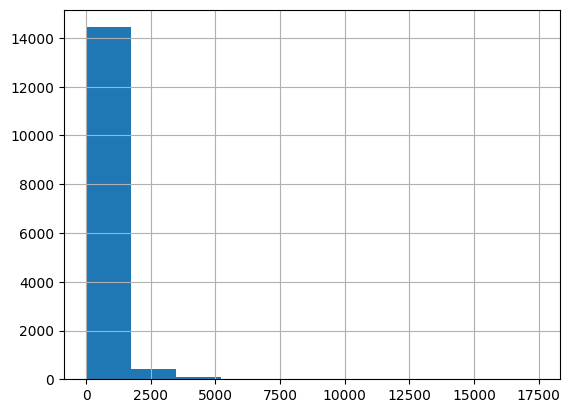

In [129]:
cc_data['body_n_words'].hist()

In [130]:
len(cc_data[cc_data['body_n_words'] < 4000]) / len(cc_data)

0.9934

In [131]:
# dropping outliers
pre_final_data = cc_data[cc_data['body_n_words'] <= 4000].copy()
cc_final_data = pre_final_data.drop(["body_n_words"], axis=1)

#### Overview

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

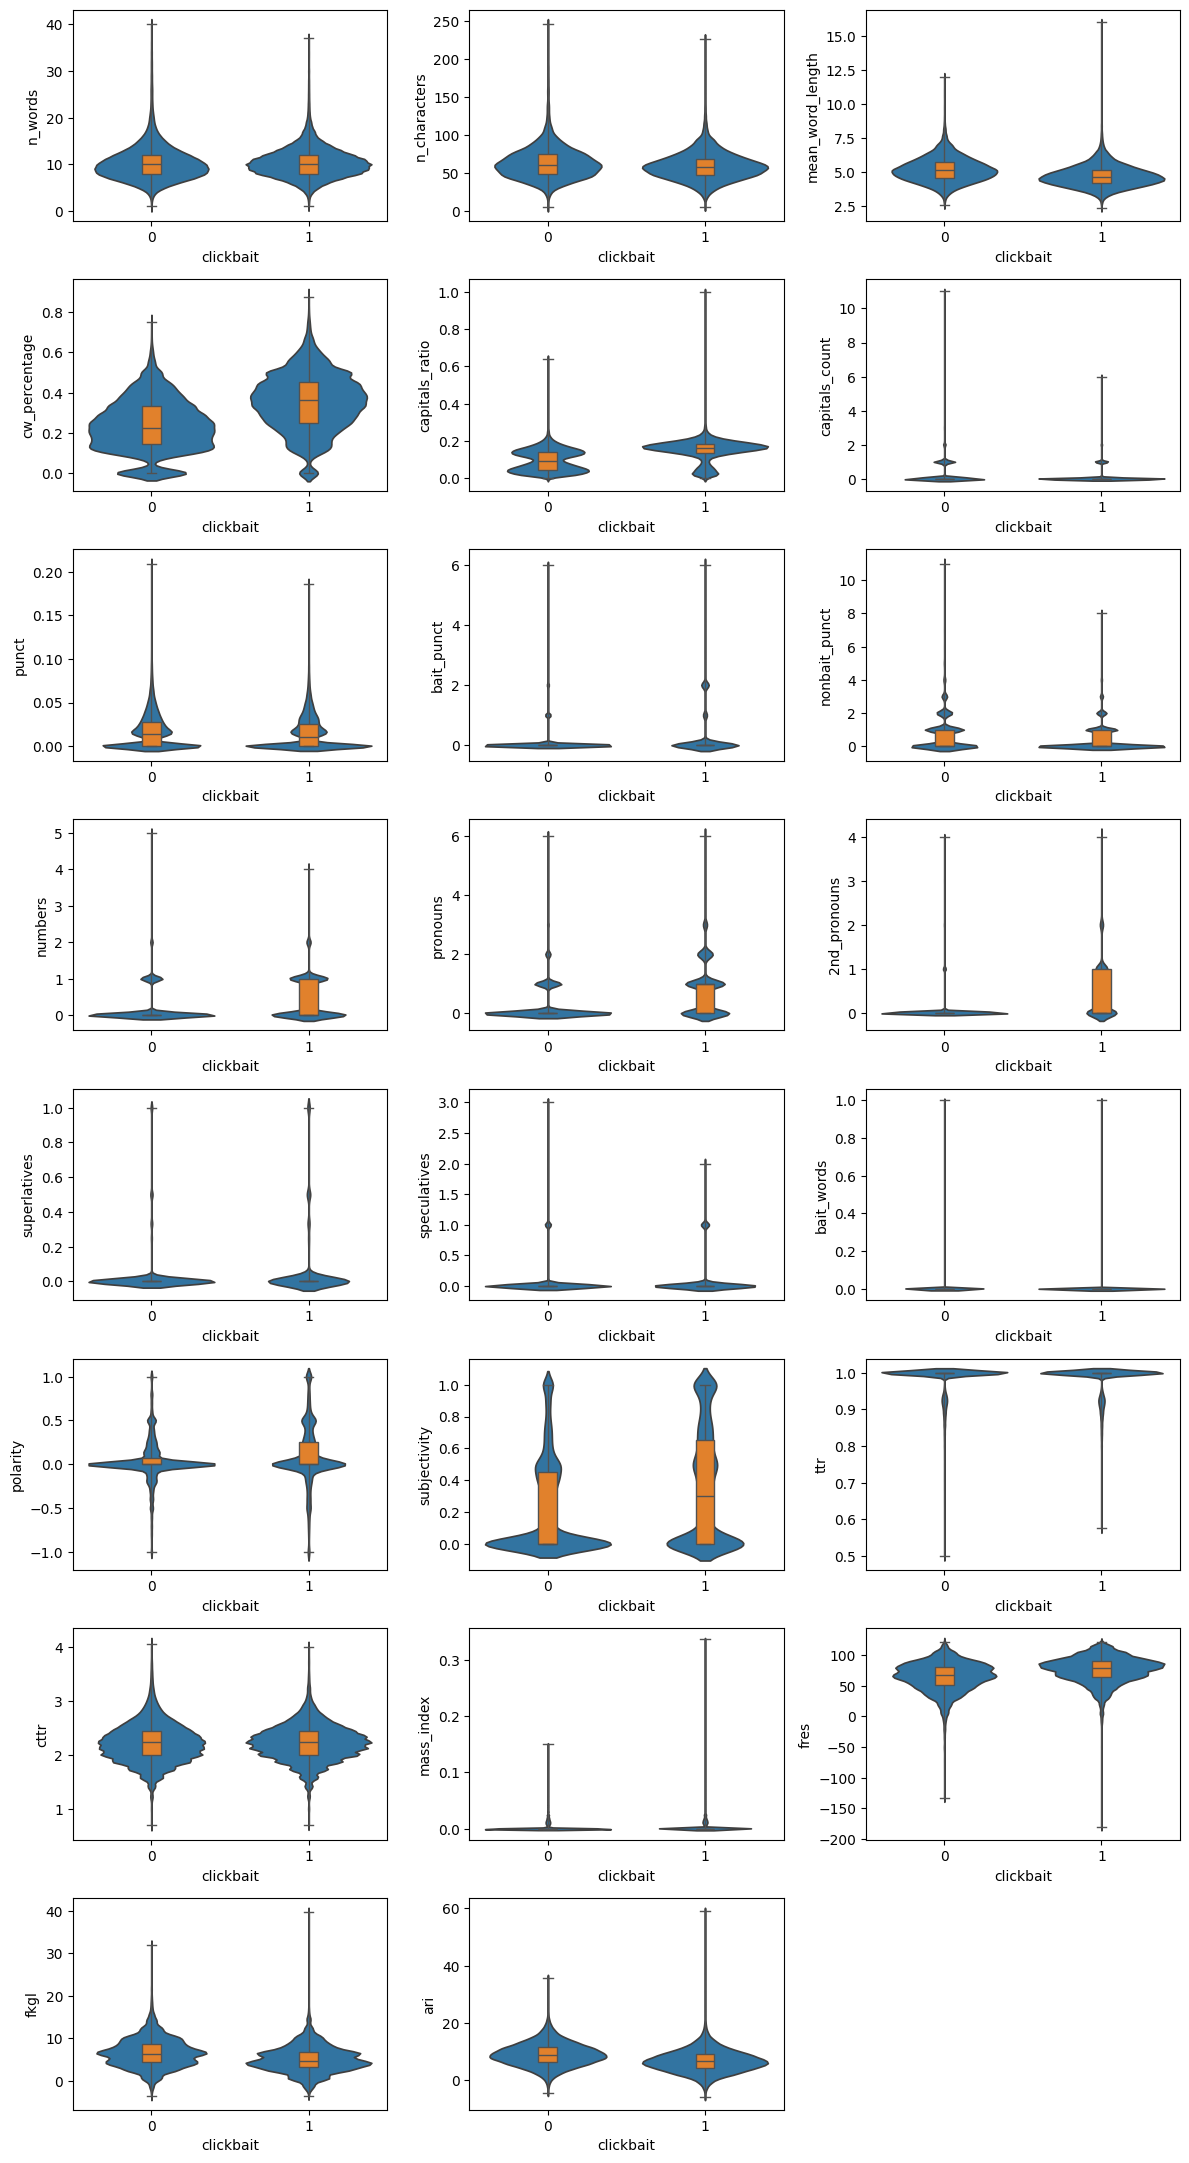

In [144]:
plt.figure(figsize=(12,24))
columns = final_data.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(9, 3, i+1)
    ax = sns.violinplot(x='clickbait', y=col, data=final_data, inner=None)
    sns.boxplot(x='clickbait', y=col, data=final_data, width=0.12, whis=(0, 100), ax=ax)
plt.tight_layout()
plt.show()

Half of the measures have almost identical characteristics for bait and non-bait. 

The only clear difference in median is in average percentage of common words, which is higher for clickbaits. There are also differences for other variables (capital letters, subjectivity, metrics measuring difficulty of the text) but they are rather not substantial

Many metrics have bigger standard deviation for clickbaits e.g., avg word length, punctuation usage, numbers or mass index.

#### Analysis

In [145]:
def print_metrics(data, column, round_val=2):

    data_0 = data[data['clickbait'] == 0][column]
    data_1 = data[data['clickbait'] == 1][column]

    vals_0 = data_0.describe()
    vals_1 = data_1.describe()

    vals_0.drop(['count', '25%', '75%'], inplace=True)
    vals_1.drop(['count', '25%', '75%'], inplace=True)

    vals_1.at['ratio'] = round(vals_1['mean'] / vals_0['mean'], 2)

    vals_0 = vals_0.apply(lambda x: round(x, round_val))
    vals_1 = vals_1.apply(lambda x: round(x, round_val))

    vals_0.at['ratio'] = ''

    vals_0.name = 'non clickbait'
    vals_1.name = 'clickbait'

    print(tabulate(pd.DataFrame([vals_0, vals_1]), headers=vals_1.index))

def plot_metrics(data, column):
    ax = sns.violinplot(x='clickbait', y=column, data=data, inner=None)
    sns.boxplot(x='clickbait', y=column, data=data, width=0.12, whis=(0, 100), ax=ax)

def print_merged(metric, on='title'):
    nonbait = " ".join(final_data[final_data['clickbait']==0][on].to_list())
    bait = " ".join(final_data[final_data['clickbait']==1][on].to_list())
    print(f"{metric.upper()}")
    print(f"non clickbait:  {round(metrics_functions[metric](nonbait), 3)}")
    print(f"clickbait:      {round(metrics_functions[metric](bait), 3)}")

##### Number of words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   10.37   3.84      1     10     40
clickbait       10.46   3.3       1     10     37  1.01


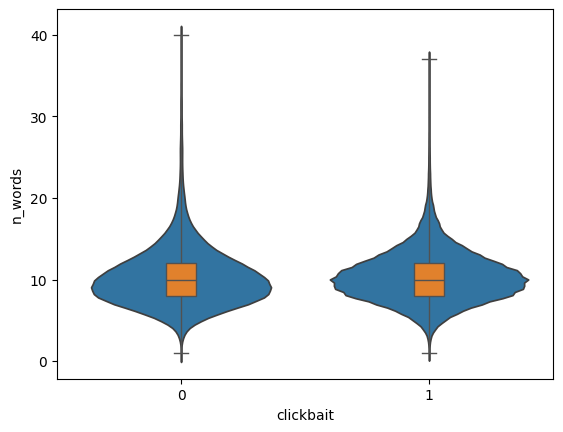

In [146]:
print_metrics(final_data, 'n_words')
plot_metrics(final_data, 'n_words')

In [93]:
# No difference at all for titles

##### Number of characters

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   64.15  22.36      6     61    246
clickbait       59.82  19.13      6     58    227  0.93


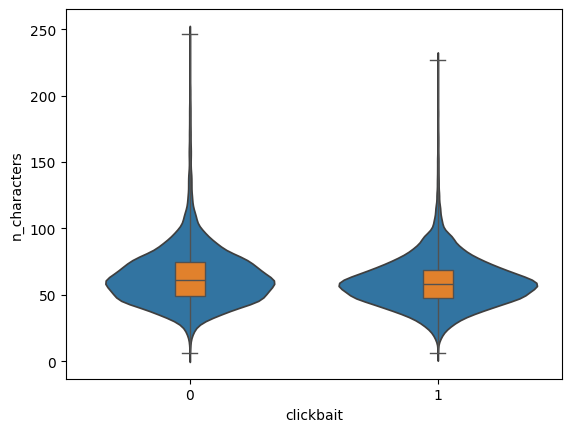

In [147]:
print_metrics(final_data, 'n_characters')
plot_metrics(final_data, 'n_characters')

In [148]:
# non clickbaits use a little bit more characters than clickbaits

##### Mean word length

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    5.2    0.9    2.57   5.12     12
clickbait        4.72   0.79   2.33   4.64     16  0.91


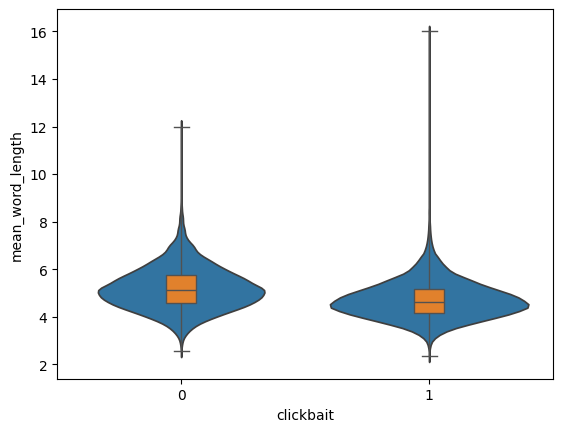

In [149]:
print_metrics(final_data, 'mean_word_length')
plot_metrics(final_data, 'mean_word_length')

In [172]:
# slightly shorter words on average for clickbaits

##### Common words percentage

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.24   0.13      0   0.22   0.75
clickbait        0.35   0.14      0   0.36   0.88  1.5


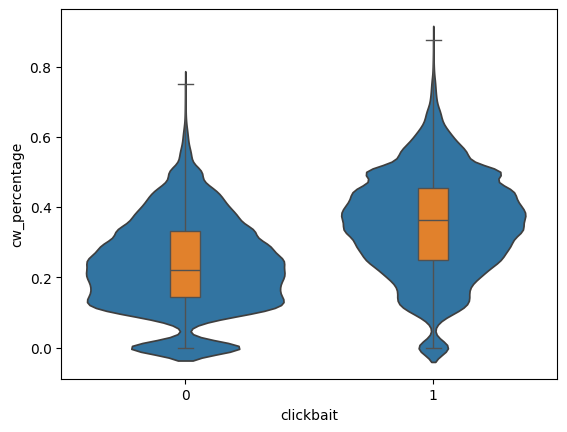

In [150]:
print_metrics(shortened_metrics, 'cw_percentage')
plot_metrics(shortened_metrics, 'cw_percentage')

In [104]:
# significant difference, clickbaits have more common words

##### Capital letters ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.1    0.06      0   0.09   0.64
clickbait        0.15   0.06      0   0.16   1     1.56


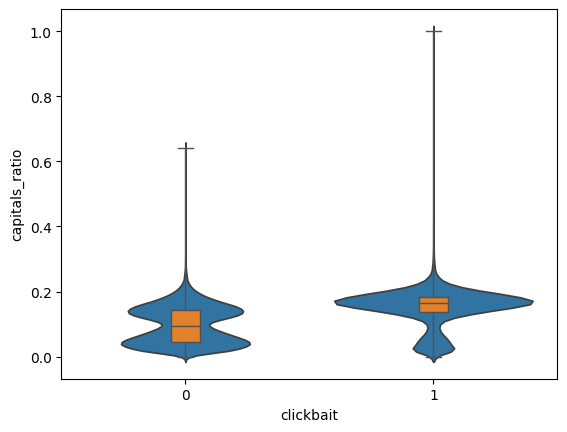

In [151]:
print_metrics(shortened_metrics, 'capitals_ratio')
plot_metrics(shortened_metrics, 'capitals_ratio')

In [ ]:
# bigger mean and median for clickbaits

##### Capital words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.24   0.5       0      0     11
clickbait        0.12   0.37      0      0      6  0.47


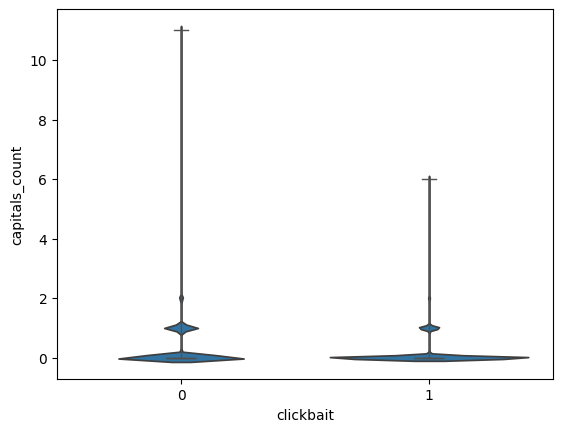

In [152]:
print_metrics(shortened_metrics, 'capitals_count')
plot_metrics(shortened_metrics, 'capitals_count')

In [32]:
# suprisingly, more full capital words are in non-clickbait titles

##### Punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.02   0.02      0   0.01   0.21
clickbait        0.02   0.02      0   0.01   0.19  0.86


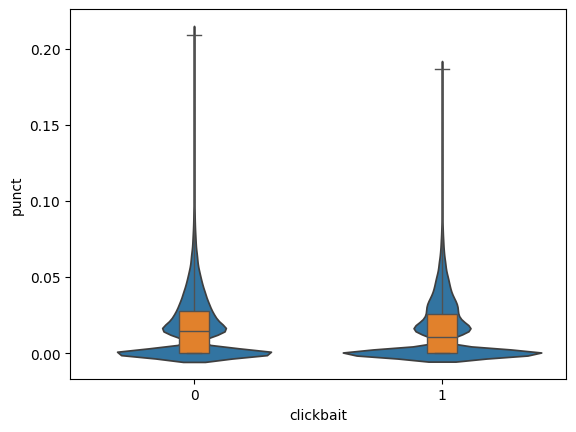

In [153]:
print_metrics(shortened_metrics, 'punct')
plot_metrics(shortened_metrics, 'punct')

In [109]:
# almost the same

##### Clickbait punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.07   0.32      0      0      6
clickbait        0.26   0.67      0      0      6  3.81


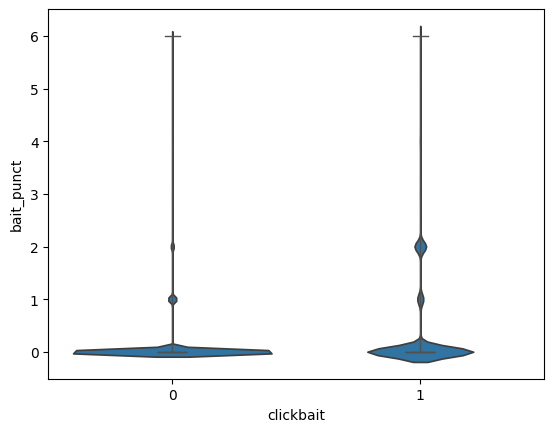

In [154]:
print_metrics(shortened_metrics, 'bait_punct')
plot_metrics(shortened_metrics, 'bait_punct')

In [112]:
# this feature was engineered based on eda, as we can see the mean count is way higher for clickbaits

##### Non clickbait punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.74   0.99      0      0     11
clickbait        0.36   0.73      0      0      8  0.49


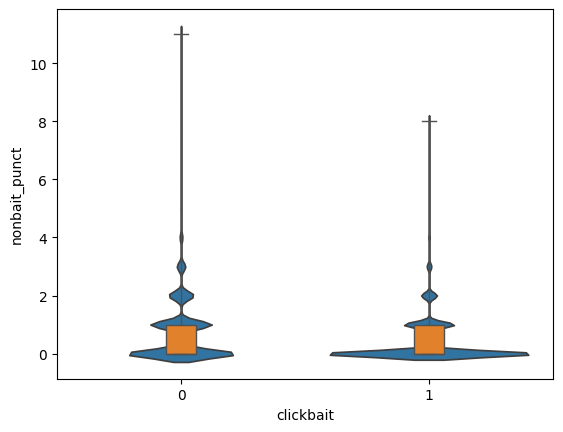

In [155]:
print_metrics(shortened_metrics, 'nonbait_punct')
plot_metrics(shortened_metrics, 'nonbait_punct')

In [ ]:
# same as before, this feature was properly engineered, big difference in distribution, mean count is higher for non clickbaits

##### Numbers usage

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.18   0.43      0      0      5
clickbait        0.4    0.56      0      0      4  2.29


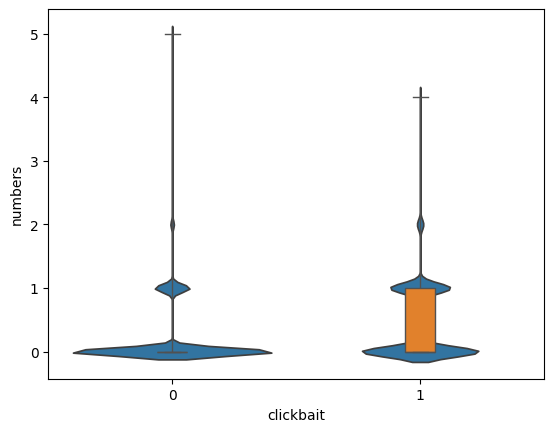

In [156]:
print_metrics(shortened_metrics, 'numbers')
plot_metrics(shortened_metrics, 'numbers')

In [118]:
# way more numbers used in clickbaits

##### Pronouns

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.25   0.56      0      0      6
clickbait        0.79   0.87      0      1      6  3.15


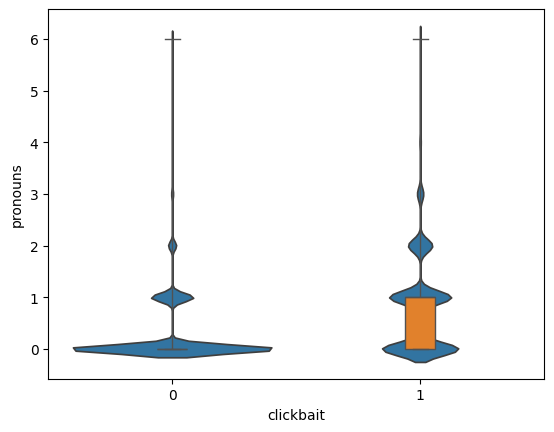

In [157]:
print_metrics(shortened_metrics, 'pronouns')
plot_metrics(shortened_metrics, 'pronouns')

In [158]:
# median is 1 for clickbaits, which is a lot. of course average usage is also bigger for clickbaits

##### 2 person pronouns

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.03   0.19      0      0      4
clickbait        0.41   0.64      0      0      4  14.14


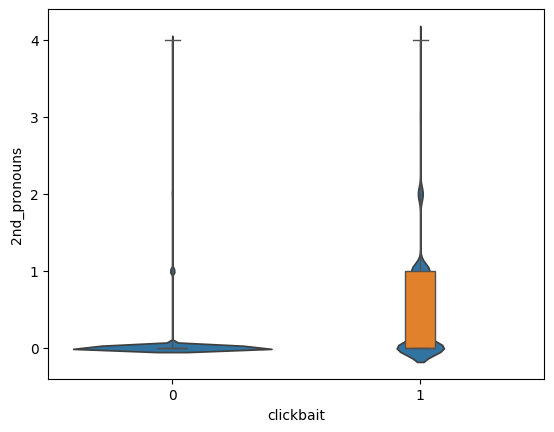

In [159]:
print_metrics(shortened_metrics, '2nd_pronouns')
plot_metrics(shortened_metrics, '2nd_pronouns')

In [160]:
# here the difference is huge, most non-bait titles do not use 2nd person pronouns

##### Superlatives

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.02   0.12      0      0      1
clickbait        0.05   0.19      0      0      1  2.26


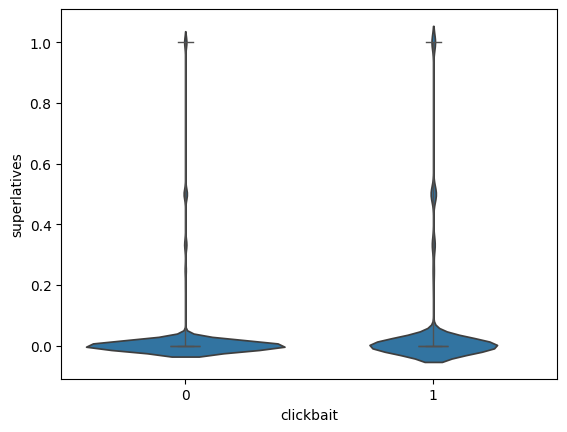

In [161]:
print_metrics(shortened_metrics, 'superlatives')
plot_metrics(shortened_metrics, 'superlatives')

In [125]:
# superlatives are used two times more in clickbaits, however they are still rare 

##### Speculatives

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.05   0.22      0      0      3
clickbait        0.07   0.27      0      0      2  1.51


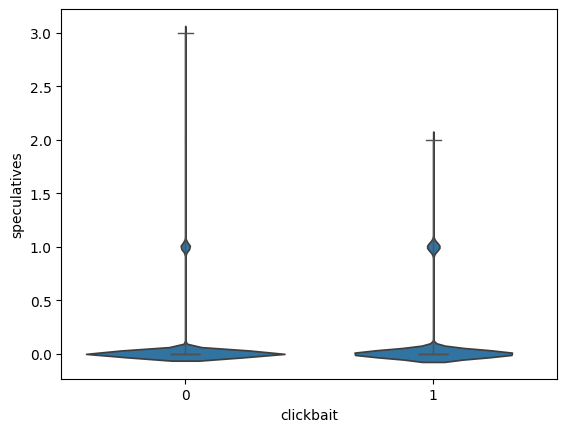

In [162]:
print_metrics(shortened_metrics, 'speculatives')
plot_metrics(shortened_metrics, 'speculatives')

In [163]:
# the same happens in here, but the ratio is smaller

##### Bait words

In [ ]:
# TODO

##### Polarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.04   0.23     -1      0      1
clickbait        0.1    0.33     -1      0      1  2.79


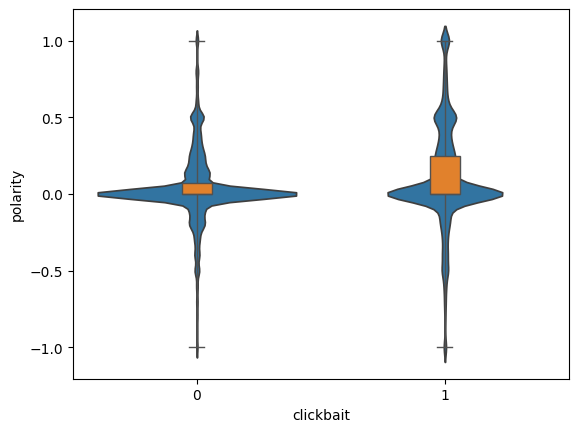

In [164]:
print_metrics(shortened_metrics, 'polarity')
plot_metrics(shortened_metrics, 'polarity')

In [165]:
# polarity is more varied in clickbaits than in non=clickbait headlines and, interestingly, more positive than negative on average

##### Subjectivity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.23   0.29      0    0        1
clickbait        0.36   0.36      0    0.3      1  1.58


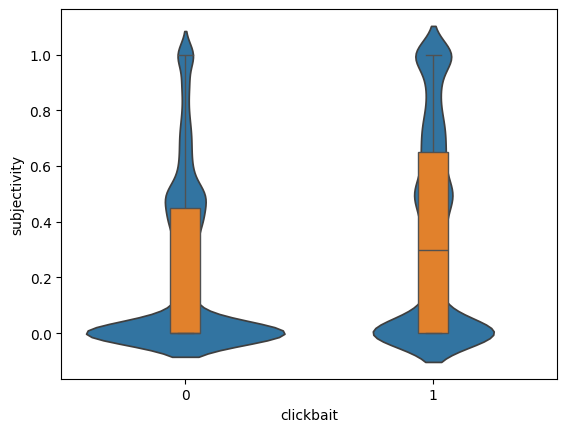

In [166]:
print_metrics(shortened_metrics, 'subjectivity')
plot_metrics(shortened_metrics, 'subjectivity')

In [ ]:
# clickbaits titles are more subjective. Both mean and median is bigger for clickbaits

##### TTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.98   0.04   0.5       1      1
clickbait        0.98   0.04   0.58      1      1  1.0


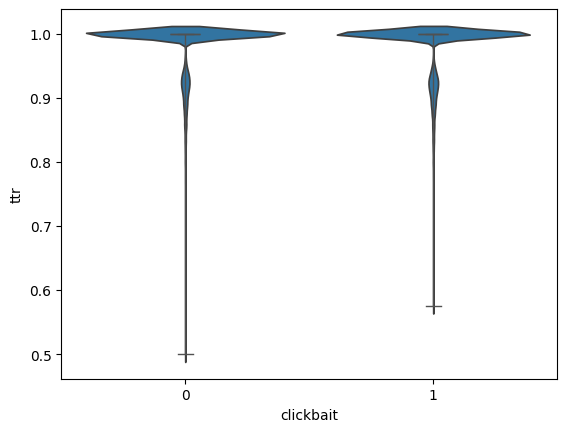

In [167]:
print_metrics(final_data, 'ttr')
plot_metrics(final_data, 'ttr')

In [199]:
# No difference at all, but its not strange as for most titles ttr will be 1, cause titles are so short its hard to not use all unique words
# lets check lexical diversity over all titles

In [168]:
print_merged('ttr')

TTR
non clickbait:  0.129
clickbait:      0.098


In [ ]:
# clickbaits are less lexically diversed, they are similar to each other

##### CTTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    2.22   0.37   0.71   2.24   4.06
clickbait        2.23   0.33   0.71   2.24   4     1.0


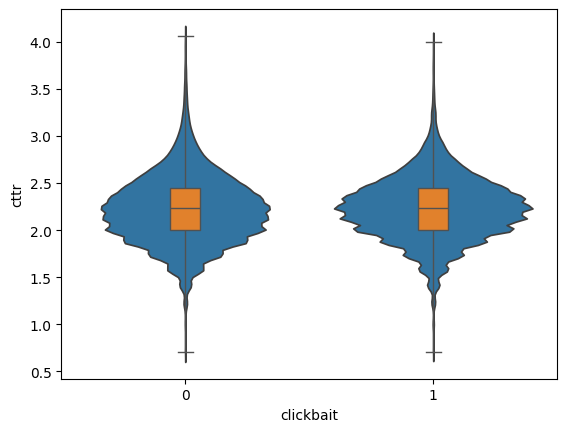

In [169]:
print_metrics(shortened_metrics, 'cttr')
plot_metrics(shortened_metrics, 'cttr')

In [170]:
# a little bigger standard deviation for cttr for non-clickbaits, other than that no differences

In [171]:
print_merged('cttr')

CTTR
non clickbait:  37.446
clickbait:      28.459


In [204]:
# again non clickbaits are more diversed

##### Maas index

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait       0   0.01      0      0   0.15
clickbait           0   0.01      0      0   0.34  1.17


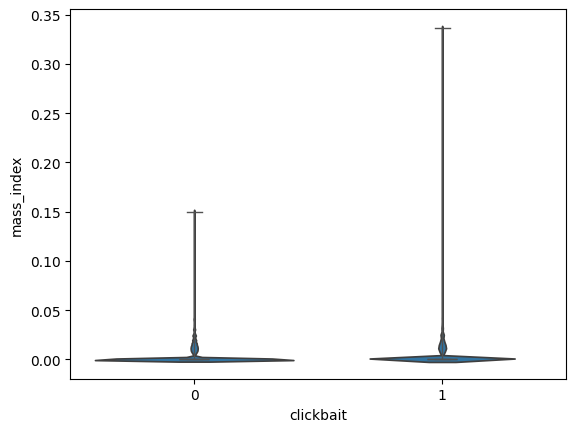

In [172]:
print_metrics(shortened_metrics, 'mass_index')
plot_metrics(shortened_metrics, 'mass_index')

In [206]:
# same issue as ttr

In [173]:
print_merged('mass_index')

MASS_INDEX
non clickbait:  0.014
clickbait:      0.016


In [208]:
# only small advantage for non clickbait headlines

##### FRES

                 mean    std      min    50%     max  ratio
-------------  ------  -----  -------  -----  ------  -------
non clickbait   64.96  23.96  -132.59  67.76  121.22
clickbait       76.26  21.38  -179.96  79.26  121.22  1.17


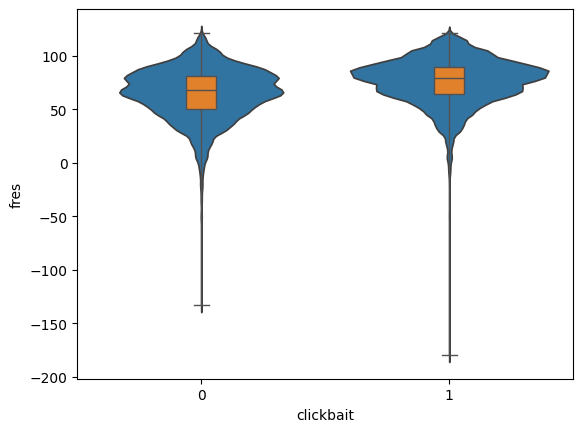

In [174]:
print_metrics(shortened_metrics, 'fres')
plot_metrics(shortened_metrics, 'fres')

In [141]:
# clickbaits headlines are easier to read

##### FKGL

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    6.69   3.42   -3.5    6.4   32
clickbait        5.16   3.08   -3.5    4.8   39.8  0.77


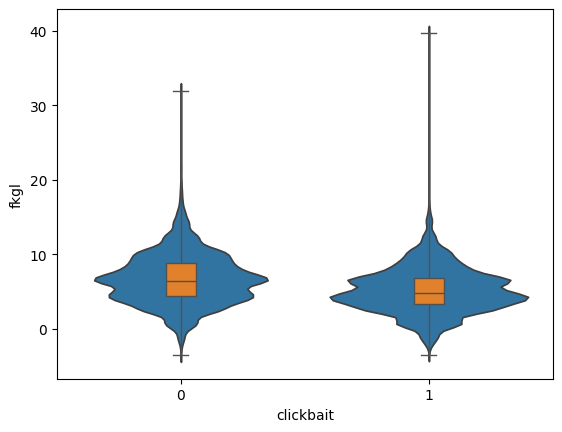

In [175]:
print_metrics(shortened_metrics, 'fkgl')
plot_metrics(shortened_metrics, 'fkgl')

In [143]:
# same results here, clickbait headlines are easier to read

##### ARI

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    9.05   4.06   -4.4    8.9   35.6
clickbait        6.66   3.87   -5.9    6.5   59.1  0.74


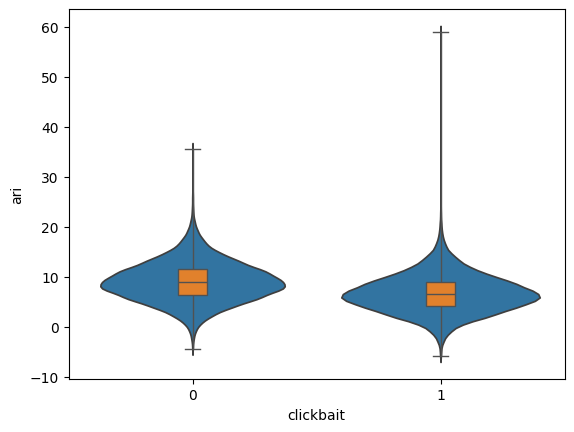

In [176]:
print_metrics(shortened_metrics, 'ari')
plot_metrics(shortened_metrics, 'ari')

In [ ]:
# distributions look similar to the fkgl

#### Summary

The differences are rather not substantial.

Clickbaits have smaller average word length (correlates with higher common words percentage), they are also easier to read. It is hard to calculate lexical diversity for titles, as they are super short. However, lexical diversity of all titles merged together is smaller for clickbaits. Clickbait headlines are also more subjective.

Measures prepared specifically for clickbaits are all higher for clickbait headlines (bait punctuation, pronouns, superlatives, speculatives, capitals ratio). What's more, numbers usage is also higher. Whats weird, capital words usage is higher for non-clickbait titles.

Clickbaits often have higher standard deviation and more outliers.  

#### Fitting models:

Even if in the previous analysis for some features there were no differences between clickbaits and non-clickbaits, those features will still be included in the model building, as they may <i>interfere</i> with others.

<Axes: >

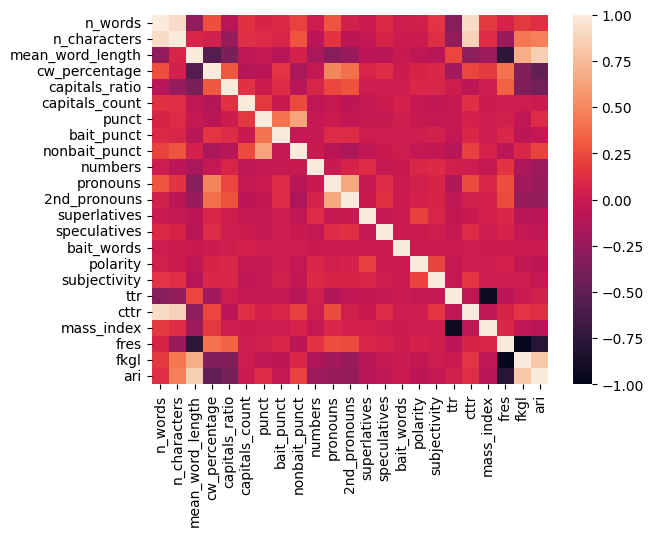

In [177]:
# check corelation
X = final_data.drop(['title', 'set', 'clickbait'], axis=1)
y = final_data['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1, annot_kws={'alpha': 0})

<Axes: >

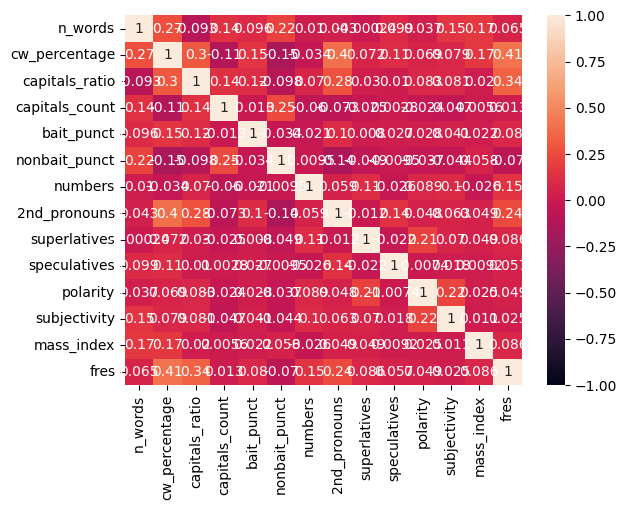

In [178]:
# dropping correlated columns:
# n_characters, mean_word_length, punctuation, pronouns, ttr, cttr
train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']
X = final_data[train_columns]
y = final_data['clickbait']

X_test = test_data[train_columns]
y_test = test_data['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [179]:
# split and prepare data
X_train = X
y_train = y

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [180]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.455408
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                31954
Model:                          Logit   Df Residuals:                    31940
Method:                           MLE   Df Model:                           13
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.3430
Time:                        14:07:36   Log-Likelihood:                -14552.
converged:                       True   LL-Null:                       -22149.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
n_words           -0.0456      0.017     -2.766      0.006      -0.078      -0.013
cw_percentage    

In [192]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.42 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4014
           1       0.79      0.78      0.79      3986

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000



Lets drop insignificant variables and fit the model again

In [182]:
cols_to_drop = ['speculatives', 'polarity', 'mass_index']
X_train = X.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test2)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.455503
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                31954
Model:                          Logit   Df Residuals:                    31943
Method:                           MLE   Df Model:                           10
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.3428
Time:                        14:08:18   Log-Likelihood:                -14555.
converged:                       True   LL-Null:                       -22149.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
n_words           -0.0475      0.016     -2.900      0.004      -0.080      -0.015
cw_percentage    

In [193]:
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.42 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4014
           1       0.79      0.78      0.79      3986

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000



<!-- We got better accuracy, but it's impossible to build a good model based only of informativeness measures of title. Also, many of them are correlated, so its enough to choose only some of them (eg n_words, fkgl, cw_percentage). 

Conclusions from the model - headlines which are easier to read (fkgl), contain less words, but have higher common words percentage are more likely to be classified as clickbait.

 -->
Pretty much identical.<br>
All coeficients correlate to the analysis.

For the sake of testing, lets put all the variables to random forest:

In [195]:
X_train = final_data.drop(['title', 'set', 'clickbait'], axis=1)
y_train = final_data['clickbait']

X_test = test_data.drop(['title', 'set', 'clickbait'], axis=1)
y_test = test_data['clickbait']

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      4014
           1       0.86      0.77      0.81      3986

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



lets add a little bit of fine tuning including dropping correlated columns, setting max depth to prevent overfitting

In [ ]:
rf = RandomForestClassifier(n_estimators=120, max_depth=15)
rf.fit(X_train[train_columns], y_train)

threshold = 0.45
predicted_proba = rf.predict_proba(X_test[train_columns])
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      4014
           1       0.83      0.78      0.80      3986

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



In [200]:
pd.DataFrame(data={'feature': rf.feature_names_in_, 'importance': rf.feature_importances_}, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
2,capitals_ratio,0.301673
1,cw_percentage,0.137744
7,2nd_pronouns,0.117426
13,fres,0.073337
6,numbers,0.062595
11,subjectivity,0.062159
5,nonbait_punct,0.055514
10,polarity,0.050043
0,n_words,0.046581
4,bait_punct,0.029430


In [ ]:
# lets train a model for cc dataset only

In [207]:
X_train_cc = cc_data.drop(['clickbait'], axis=1)
y_train_cc = cc_data['clickbait']

X_test_cc = cc_test_data.drop(['clickbait'], axis=1)
y_test_cc = cc_test_data['clickbait']

In [205]:
rf_cc = RandomForestClassifier(n_estimators=120, max_depth=15)
rf_cc.fit(X_train_cc[train_columns], y_train_cc)

RandomForestClassifier(max_depth=15, n_estimators=120)

In [235]:
threshold = 0.48
predicted_proba = rf_cc.predict_proba(X_test_cc[train_columns])
preds = (predicted_proba [:, 1] >= threshold).astype('int')

print(classification_report(y_test_cc, preds))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1810
           1       0.66      0.65      0.65      1792

    accuracy                           0.66      3602
   macro avg       0.66      0.66      0.66      3602
weighted avg       0.66      0.66      0.66      3602



In [236]:
# here we can see that CC dataset is more complex and as easy as two other ones

### Body analysis

#### Preprocessing

In [238]:
raw_body_data = cc_final_data.copy()
raw_body_test_data = cc_test_data.copy()

In [245]:
# apply metrics

# TRAIN
for name, function in tqdm(metrics_functions.items()):
    if name not in ["similarity"] :
        raw_body_data[f"body_{name}"] = raw_body_data['body'].apply(function)

name = 'similarity'
function = metrics_functions[name]
raw_body_data[f"body_{name}"] = raw_body_data.apply(lambda x: function(x['title'], x['body']), axis=1)

# TEST
for name, function in tqdm(metrics_functions.items()):
    if name not in ["similarity"] :
        raw_body_test_data[f"body_{name}"] = raw_body_test_data['body'].apply(function)

name = 'similarity'
function = metrics_functions[name]
raw_body_test_data[f"body_{name}"] = raw_body_test_data.apply(lambda x: function(x['title'], x['body']), axis=1)

raw_body_data.drop(raw_body_data[raw_body_data.isna().any(axis=1)].index, inplace=True)
raw_body_test_data.drop(raw_body_test_data[raw_body_test_data.isna().any(axis=1)].index, inplace=True)

 84%|████████▍ | 21/25 [15:37<02:16, 34.22s/it] /tmp/ipykernel_1266/3498089116.py:123: UserWarning: The text is 16 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_1266/3498089116.py:123: UserWarning: The text is 9 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_1266/3498089116.py:123: UserWarning: The text is 10 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_1266/3498089116.py:123: UserWarning: The text is 11 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_1266/3498089116.py:123: UserWarning: The text is 35 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_1266/3498089116.py:123: UserWarning: T

In [246]:
raw_body_data.to_csv("../data/inf_measures_data/full_data.csv", index=False)
raw_body_test_data.to_csv("../data/inf_measures_data/full_test_data.csv", index=False)

In [11]:
raw_body_data = pd.read_csv("../data/inf_measures_data/full_data.csv")
raw_body_test_data = pd.read_csv("../data/inf_measures_data/full_test_data.csv")

In [247]:
body_columns = [col for col in raw_body_data.columns if col.startswith("body_")]

In [248]:
# changing count columns to ratio by dividing counts by either body_n_characters or body_n_words
# all titles are relatively short and we are curious if some phrase was used or not. however in article bodies we need to check the ratio, as the articles differ much in length

body_data = raw_body_data.copy()
body_test_data = raw_body_test_data.copy()

for count_col in body_columns[5:15]:
    if count_col == 'body_punct':
        # its already calculated as ratio
        continue

    print(f"processing {count_col}")

    # TRAIN
    if 'punct' in count_col:
        body_data[count_col] = body_data.apply(lambda x: x[count_col] / x['body_n_characters'], axis=1)
    else:
        body_data[count_col] = body_data.apply(lambda x: x[count_col] / x['body_n_words'], axis=1)

    # TEST
    if 'punct' in count_col:
        body_test_data[count_col] = body_test_data.apply(lambda x: x[count_col] / x['body_n_characters'], axis=1)
    else:
        body_test_data[count_col] = body_test_data.apply(lambda x: x[count_col] / x['body_n_words'], axis=1)
    

processing body_capitals_count
processing body_bait_punct
processing body_nonbait_punct
processing body_numbers
processing body_pronouns
processing body_2nd_pronouns
processing body_superlatives
processing body_speculatives
processing body_bait_words


#### Overview

array([[<Axes: title={'center': 'body_n_words'}>,
        <Axes: title={'center': 'body_n_characters'}>,
        <Axes: title={'center': 'body_mean_word_length'}>,
        <Axes: title={'center': 'body_cw_percentage'}>,
        <Axes: title={'center': 'body_capitals_ratio'}>],
       [<Axes: title={'center': 'body_capitals_count'}>,
        <Axes: title={'center': 'body_punct'}>,
        <Axes: title={'center': 'body_bait_punct'}>,
        <Axes: title={'center': 'body_nonbait_punct'}>,
        <Axes: title={'center': 'body_numbers'}>],
       [<Axes: title={'center': 'body_pronouns'}>,
        <Axes: title={'center': 'body_2nd_pronouns'}>,
        <Axes: title={'center': 'body_superlatives'}>,
        <Axes: title={'center': 'body_speculatives'}>,
        <Axes: title={'center': 'body_bait_words'}>],
       [<Axes: title={'center': 'body_polarity'}>,
        <Axes: title={'center': 'body_subjectivity'}>,
        <Axes: title={'center': 'body_ttr'}>,
        <Axes: title={'center': 'bo

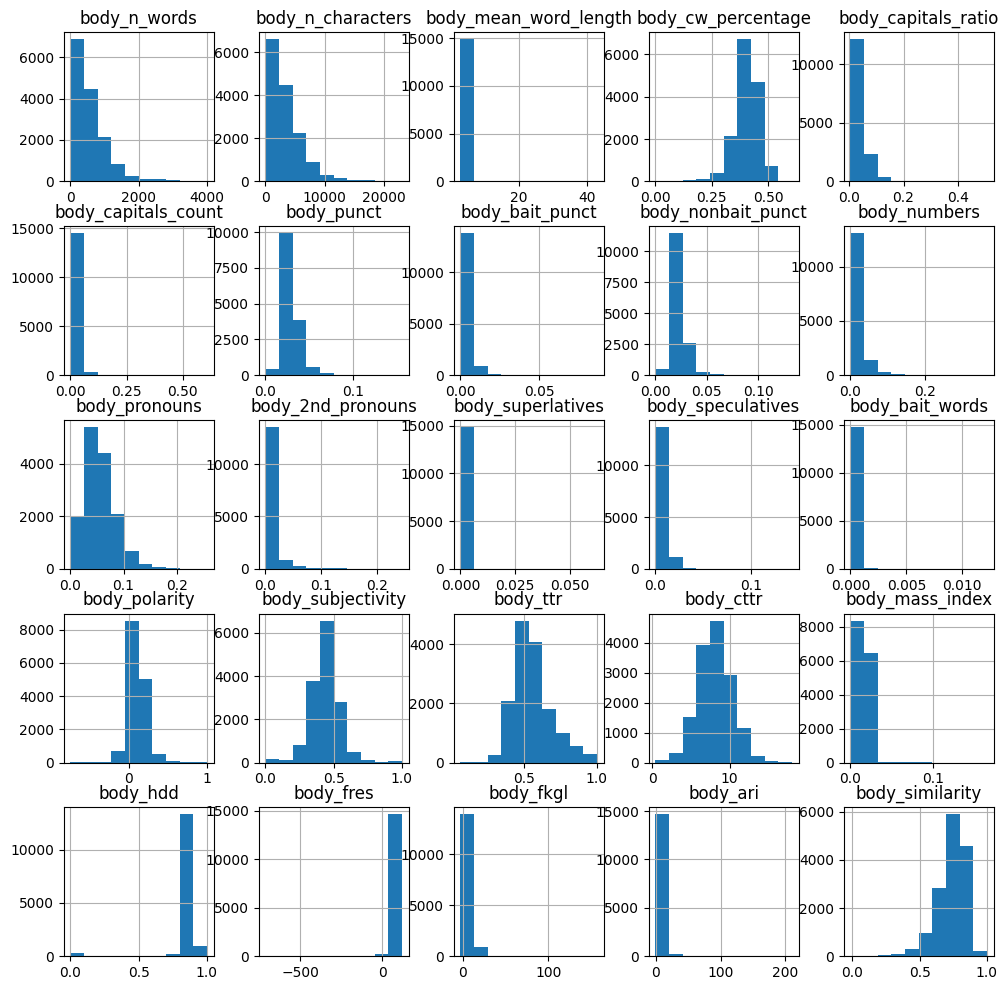

In [249]:
# check histograms
body_data[body_columns].hist(figsize=(12,12))

Now let's plot violinplots, as there we can find insights of the relationships of each variable with target var

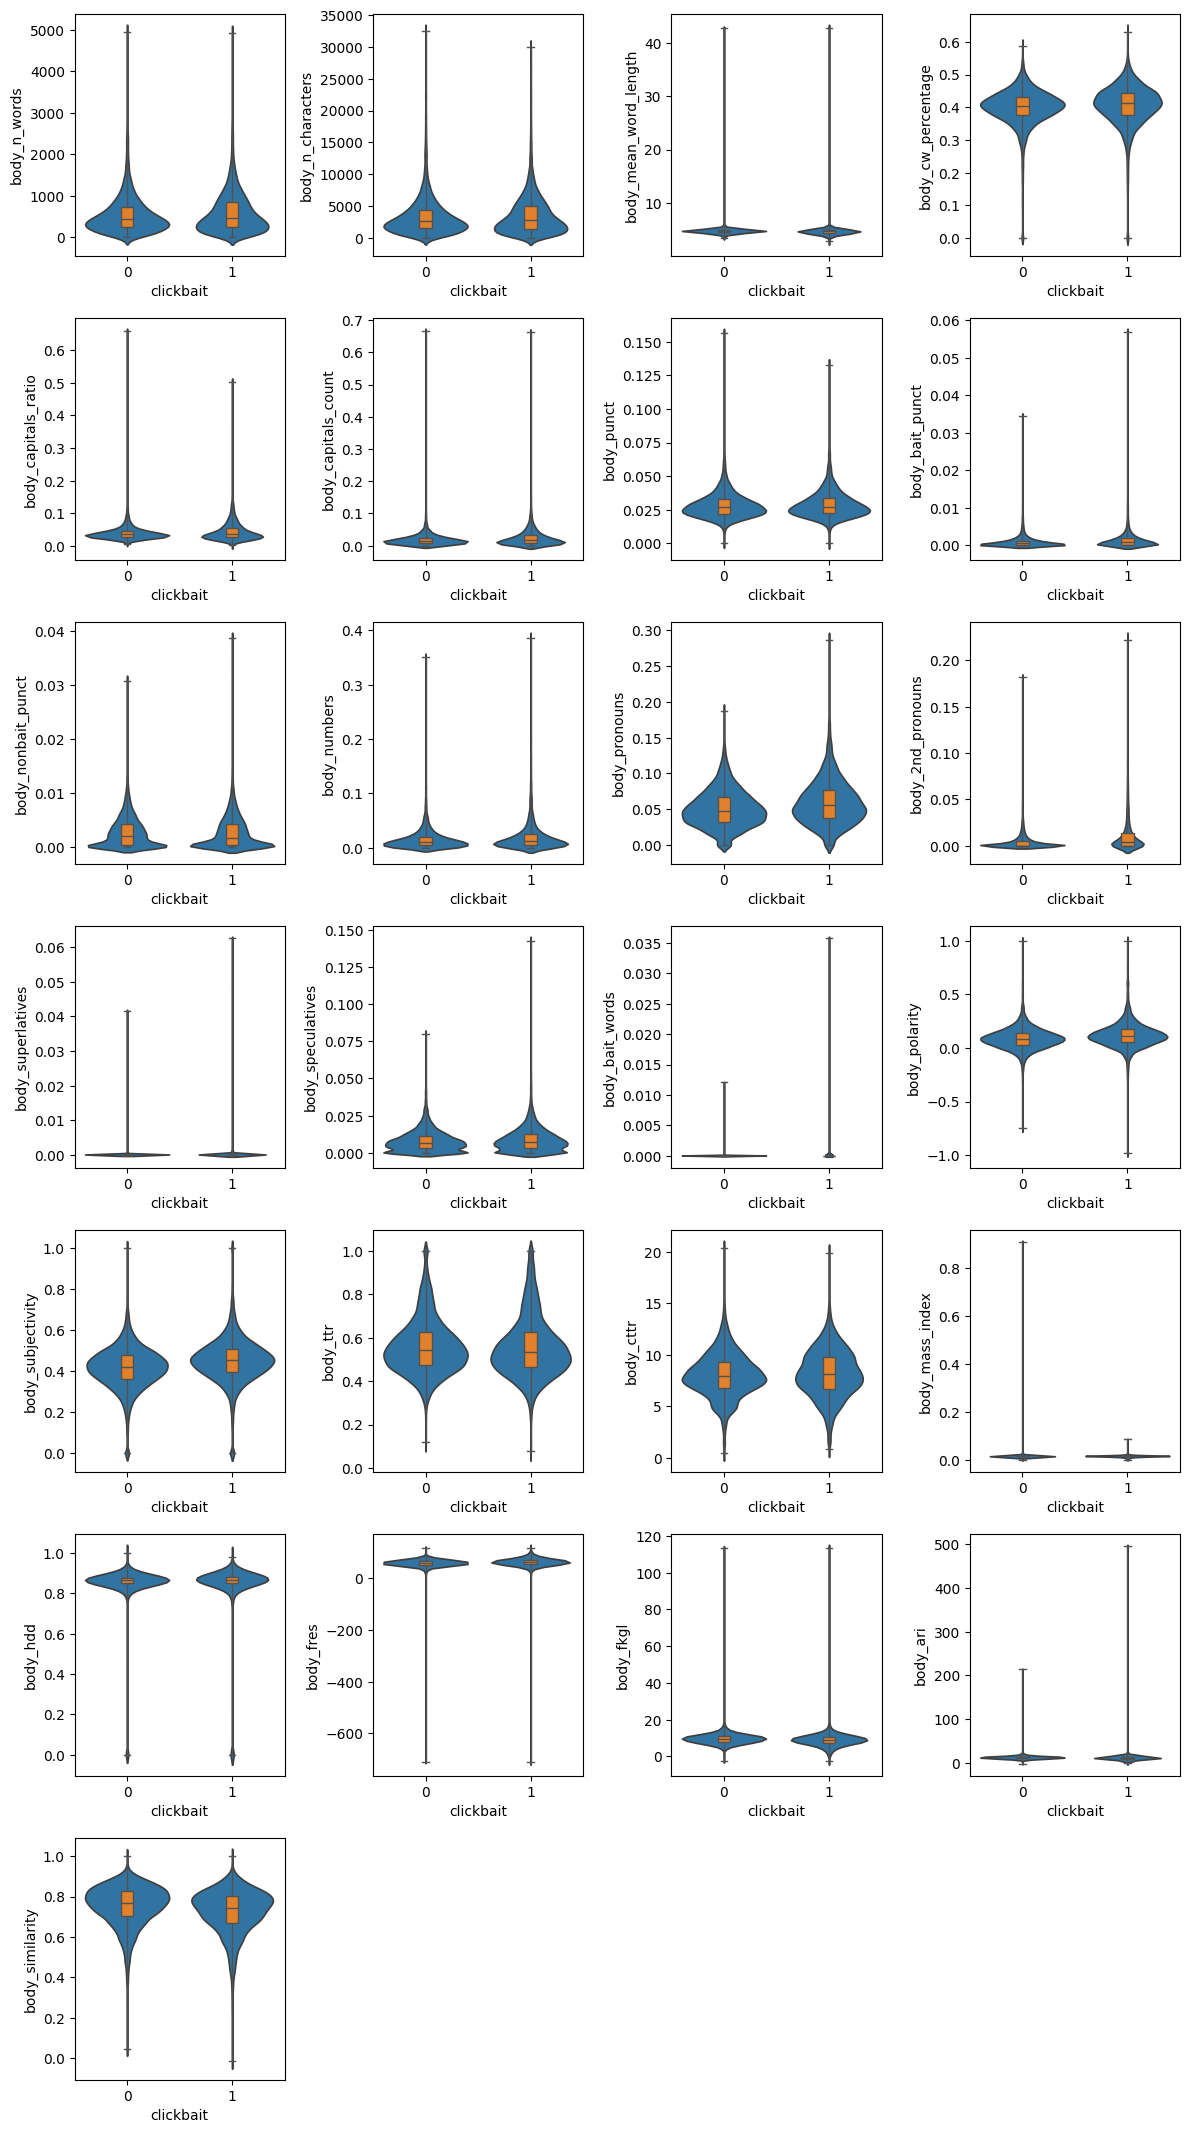

In [96]:
plt.figure(figsize=(12,24))
columns = body_columns
for i, col in enumerate(columns):
    plt.subplot(8, 4, i+1)
    ax = sns.violinplot(x='clickbait', y=col, data=body_data, inner=None)
    sns.boxplot(x='clickbait', y=col, data=body_data, width=0.12, whis=(0, 100), ax=ax)
plt.tight_layout()
plt.show()

Due to many outliers, its hard to see the differences. Lets analyze each metric alone and print some numerical metrics.

#### Analysis

##### Number of words 

                 mean     std    min    50%    max  ratio
-------------  ------  ------  -----  -----  -----  -------
non clickbait  554.36  484.62      2    418   3985
clickbait      598.37  515.94      2    463   3973  1.08


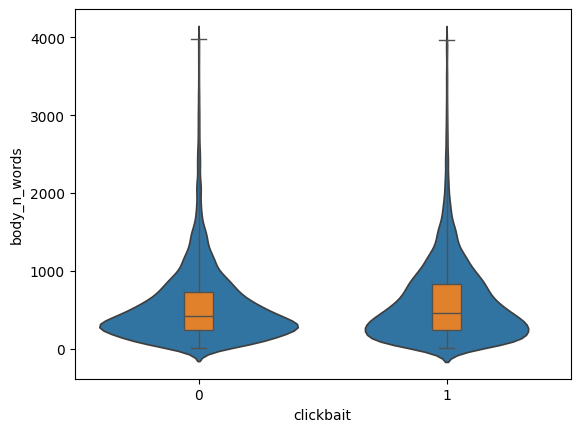

In [250]:
print_metrics(body_data, 'body_n_words')
plot_metrics(body_data, 'body_n_words')

In [ ]:
# we could reason that clickbaits are longer on the average, but probably its not a rule

##### Number of characters

                  mean      std    min     50%    max  ratio
-------------  -------  -------  -----  ------  -----  -------
non clickbait  3323.43  2870.15     16  2532.5  22949
clickbait      3555.14  3040.32     16  2774.5  22941  1.07


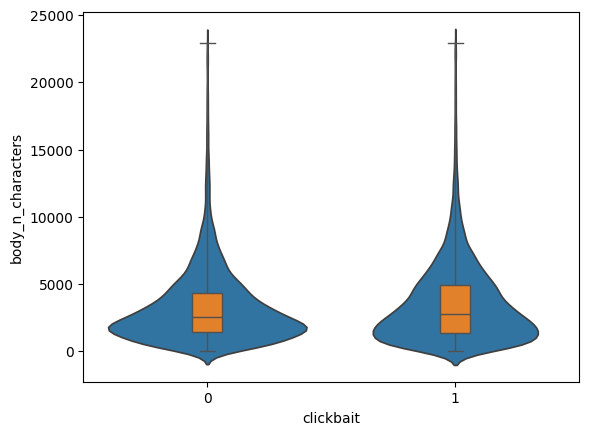

In [251]:
print_metrics(body_data, 'body_n_characters')
plot_metrics(body_data, 'body_n_characters')

In [ ]:
# charts identical as the word distributions

##### Mean word length

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    4.75   0.41   3.1    4.74  14.92
clickbait        4.67   0.83   2.78   4.65  42.75  0.98


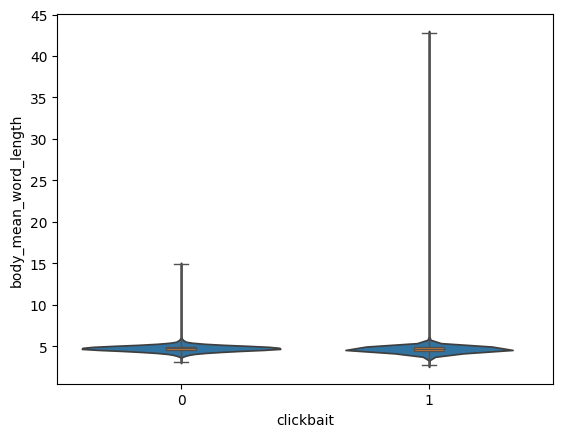

In [252]:
print_metrics(body_data, 'body_mean_word_length')
plot_metrics(body_data, 'body_mean_word_length')

In [111]:
# words are just a little bit shorter for clickbait articles

##### Common words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.402  0.052      0  0.405  0.574
clickbait       0.406  0.061      0  0.411  0.605  1.01


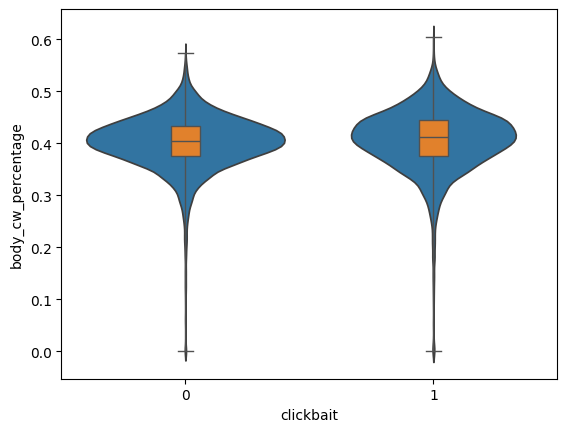

In [253]:
print_metrics(body_data, 'body_cw_percentage', round_val=3)
plot_metrics(body_data, 'body_cw_percentage')

In [ ]:
# slightly more common words for clickbait articles

##### Capital characters ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.039  0.02   0.008  0.035  0.398
clickbait       0.045  0.031  0.007  0.036  0.503  1.15


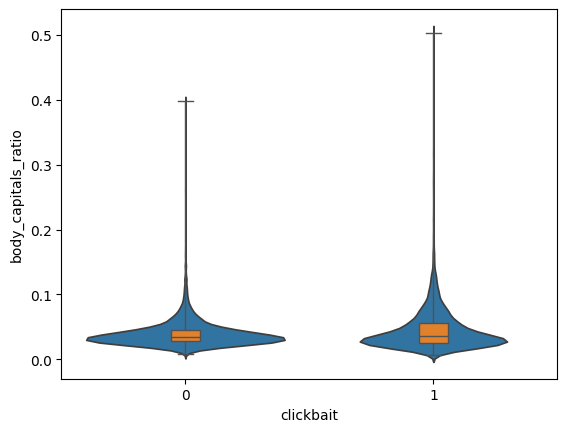

In [254]:
print_metrics(body_data, 'body_capitals_ratio', round_val=3)
plot_metrics(body_data, 'body_capitals_ratio')

In [ ]:
# the difference is visible, there are more capital letters in clickbait articles

##### Capital words ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.013  0.017      0  0.009  0.307
clickbait       0.016  0.025      0  0.009  0.606  1.27


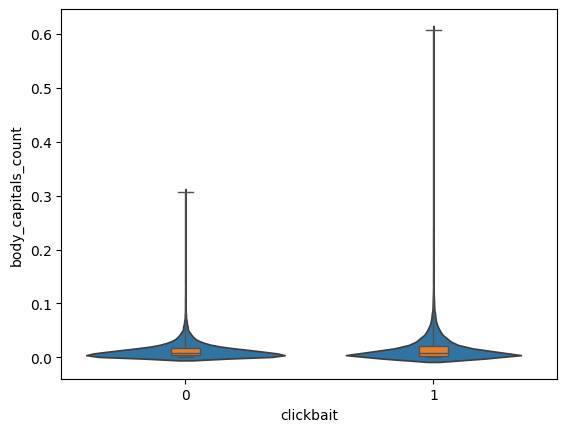

In [255]:
print_metrics(body_data, 'body_capitals_count', round_val=3)
plot_metrics(body_data, 'body_capitals_count')

In [ ]:
# little difference is visible on charts and stats with more full capital words in clickbait articles

##### Punctuation ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.028  0.009      0  0.027  0.131
clickbait       0.029  0.011      0  0.027  0.156  1.05


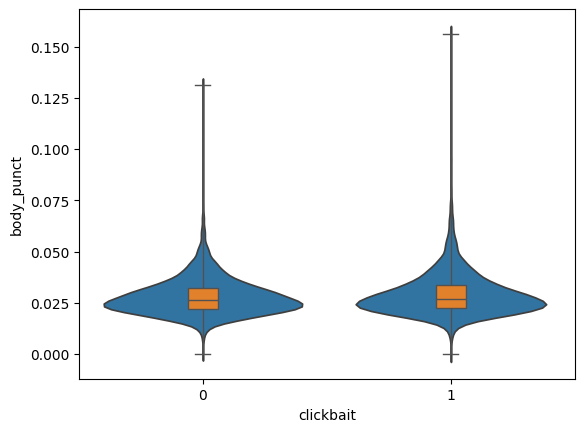

In [256]:
print_metrics(body_data, 'body_punct', round_val=3)
plot_metrics(body_data, 'body_punct')

In [ ]:
# almost no difference at all

##### Bait punctuation ratio

                 mean     std    min     50%     max  ratio
-------------  ------  ------  -----  ------  ------  -------
non clickbait  0.0031  0.0038      0  0.0018  0.0865
clickbait      0.0028  0.0041      0  0.0014  0.0568  0.92


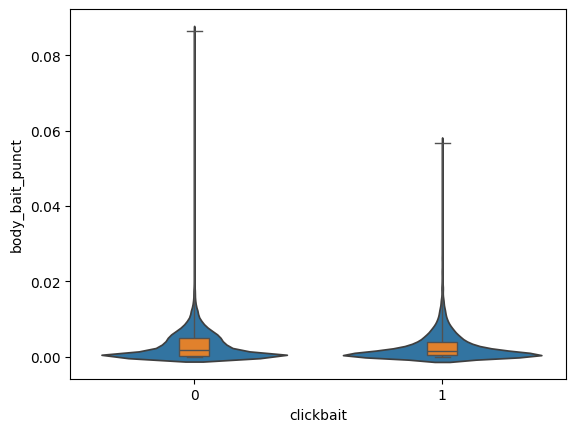

In [257]:
print_metrics(body_data, 'body_bait_punct', round_val=4)
plot_metrics(body_data, 'body_bait_punct')

In [258]:
# bait punctuation feature was prepared specifically for titles, in body the relation is slightly reversed

##### Non bait punctuation ratio

                 mean     std    min     50%     max  ratio
-------------  ------  ------  -----  ------  ------  -------
non clickbait  0.022   0.0066      0  0.0211  0.0996
clickbait      0.0234  0.0085      0  0.0219  0.1327  1.06


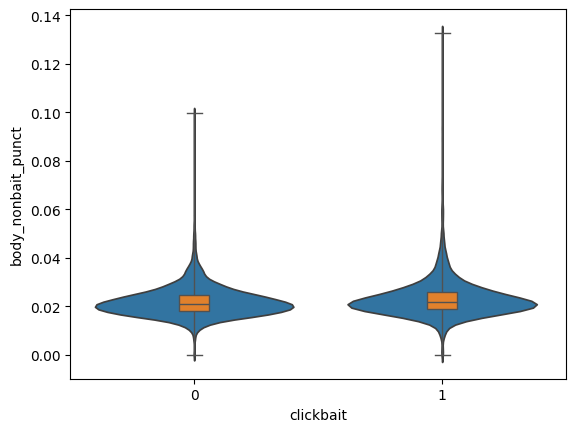

In [259]:
print_metrics(body_data, 'body_nonbait_punct', round_val=4)
plot_metrics(body_data, 'body_nonbait_punct')

In [260]:
# the same here, there are no differences in means and medians in opposition to what happens in headlines

##### Numbers ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.016  0.02       0  0.011  0.366
clickbait       0.02   0.026      0  0.012  0.333  1.22


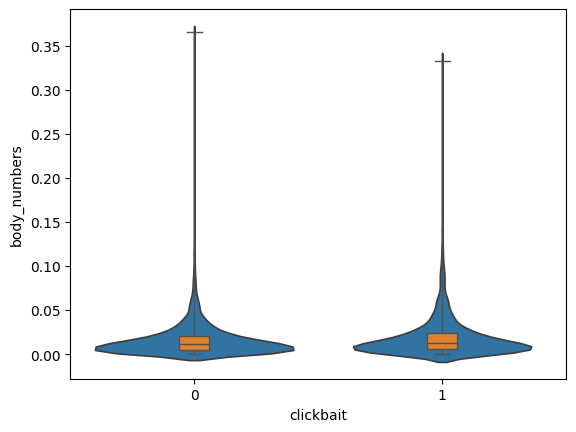

In [261]:
print_metrics(body_data, 'body_numbers', round_val=3)
plot_metrics(body_data, 'body_numbers')

In [ ]:
# we can see that clickbaits use more numbers. again, the difference is not that clear as in headlines

##### Pronouns ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.051  0.026      0  0.048  0.239
clickbait       0.06   0.032      0  0.055  0.256  1.17


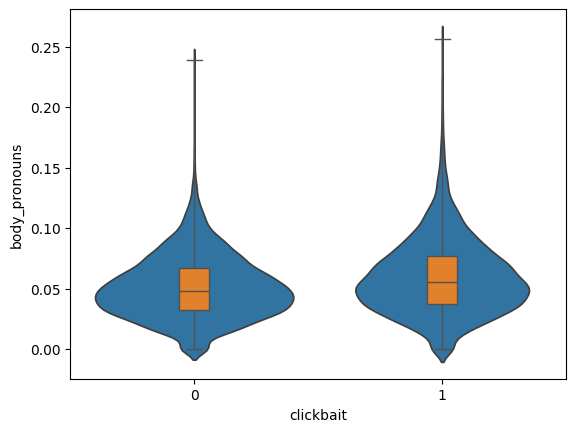

In [262]:
print_metrics(body_data, 'body_pronouns', round_val=3)
plot_metrics(body_data, 'body_pronouns')

In [ ]:
# slightly bigger usage for clickbaits

##### 2nd person pronouns ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.004  0.009      0  0      0.18
clickbait       0.012  0.023      0  0.004  0.244  2.94


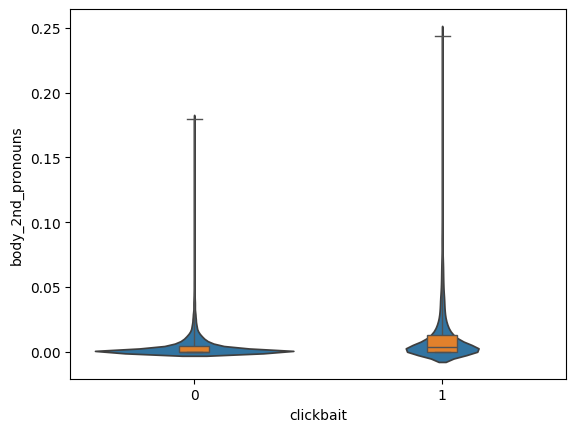

In [263]:
print_metrics(body_data, 'body_2nd_pronouns', round_val=3)
plot_metrics(body_data, 'body_2nd_pronouns')

In [ ]:
# Huge difference in this metric, almost 3 times more 2nd person pronouns appear in articles with clickbaits headlines than in non-clickbait ones.

##### Superlatives ratio

                  mean      std    min    50%      max  ratio
-------------  -------  -------  -----  -----  -------  -------
non clickbait  0.00012  0.00076      0  2e-05  0.03846
clickbait      0.00017  0.0014       0  3e-05  0.0625   1.41


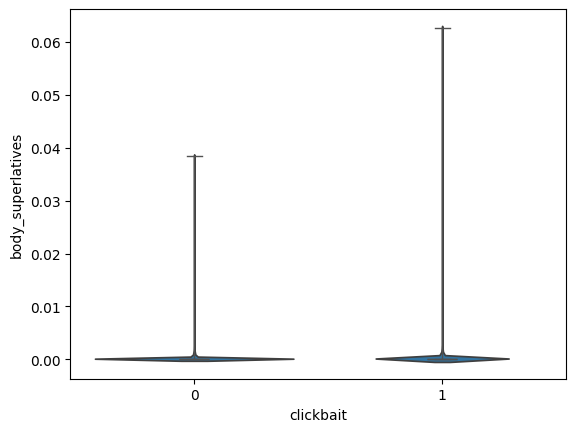

In [264]:
print_metrics(body_data, 'body_superlatives', round_val=5)
plot_metrics(body_data, 'body_superlatives')

In [ ]:
# Superlatives are such rare phenomenon that it is not worth analyzing

##### Speculatives

                 mean     std    min     50%     max  ratio
-------------  ------  ------  -----  ------  ------  -------
non clickbait  0.0051  0.0056      0  0.004   0.125
clickbait      0.0064  0.0067      0  0.0051  0.1429  1.25


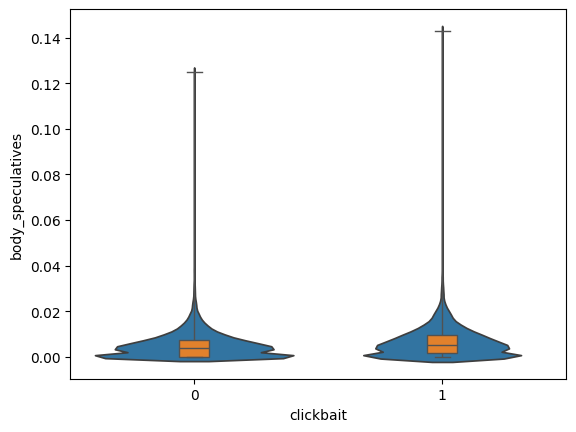

In [265]:
print_metrics(body_data, 'body_speculatives', round_val=4)
plot_metrics(body_data, 'body_speculatives')

In [40]:
# just a little bit more speculatives used in body

##### Bait words ratio

In [ ]:
# TODO 

##### Similarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.75   0.1    0.03   0.77      1
clickbait        0.72   0.11  -0.01   0.74      1  0.96


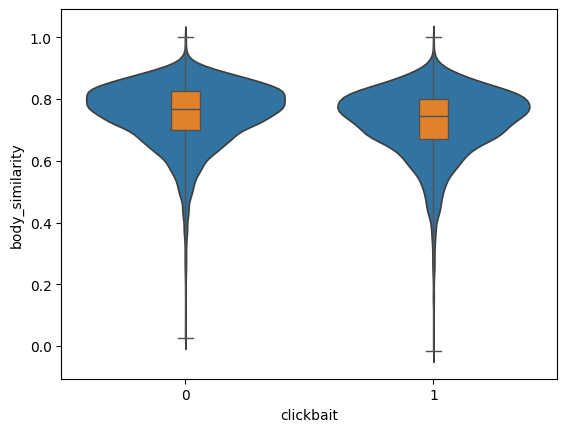

In [266]:
print_metrics(body_data, 'body_similarity', round_val=2)
plot_metrics(body_data, 'body_similarity')

In [ ]:
# results make sense as the similarity between text and title is bigger for non-clickbait articles, still the difference is really small

##### Polarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.09   0.1   -0.65   0.09    0.8
clickbait        0.12   0.12  -0.75   0.11    1    1.34


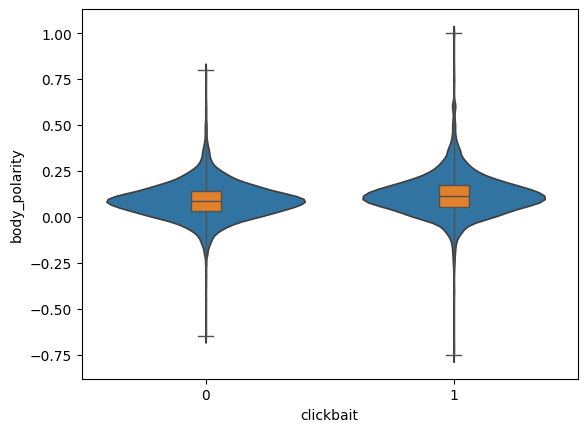

In [267]:
print_metrics(body_data, 'body_polarity', round_val=2)
plot_metrics(body_data, 'body_polarity')

In [268]:
# yet again, the polarity is more varied and little bit more positive for clickbait headlines

##### Subjectivity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.42   0.1       0   0.42      1
clickbait        0.45   0.11      0   0.45      1  1.08


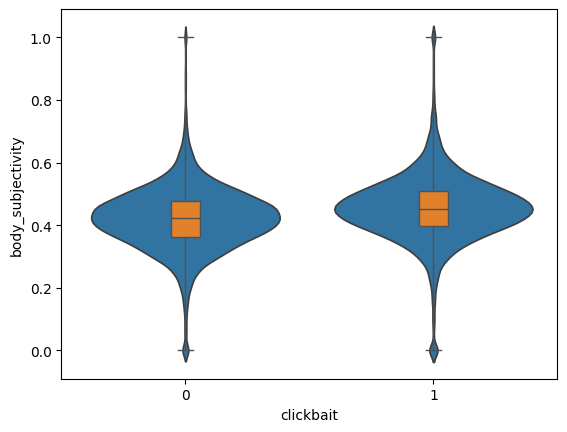

In [269]:
print_metrics(body_data, 'body_subjectivity', round_val=2)
plot_metrics(body_data, 'body_subjectivity')

In [ ]:
# clickbaits articles are more subjective

##### Type token ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.56   0.13   0.07   0.54      1
clickbait        0.56   0.14   0.08   0.53      1  1.0


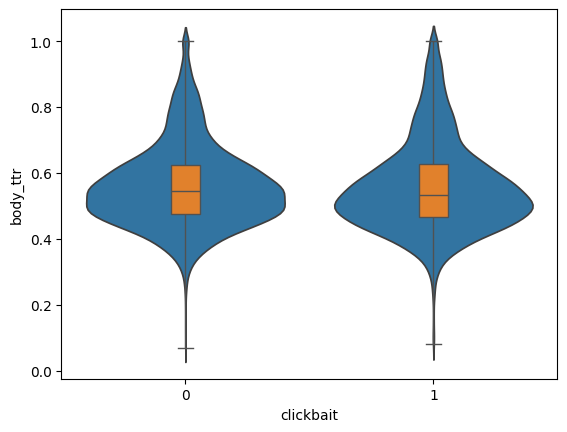

In [270]:
print_metrics(body_data, 'body_ttr', round_val=2)
plot_metrics(body_data, 'body_ttr')

In [ ]:
# the lexical diversity is almost the same with a nod to non-clickbaits articles

##### CTTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    8.01   2.04   0.52   7.9   16.72
clickbait        8.17   2.31   0.41   8.11  18.06  1.02


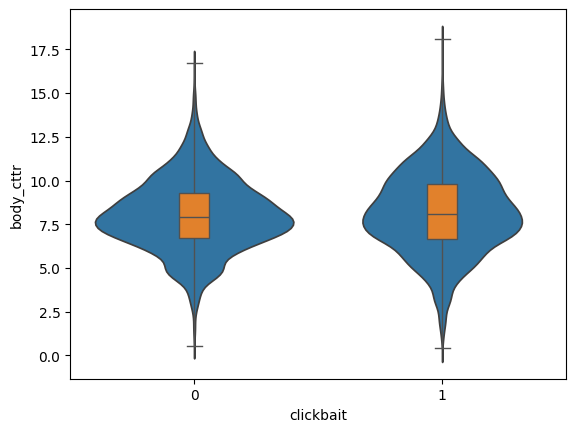

In [271]:
print_metrics(body_data, 'body_cttr', round_val=2)
plot_metrics(body_data, 'body_cttr')

In [ ]:
# clickbait articles are slightly more diversed, but again the difference is really small

##### Maas index

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   0.016  0.004      0  0.016  0.118
clickbait       0.016  0.005      0  0.016  0.166  1.0


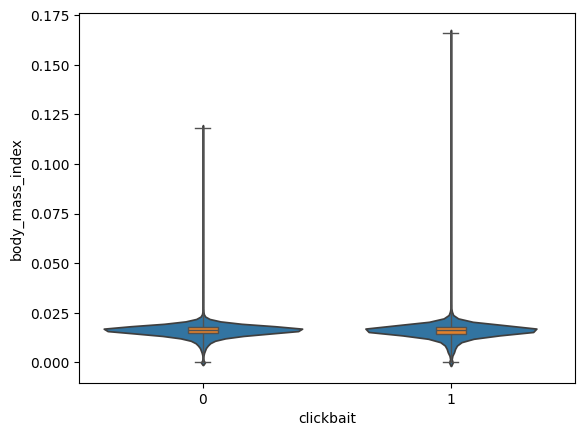

In [272]:
print_metrics(body_data, 'body_mass_index', round_val=3)
plot_metrics(body_data, 'body_mass_index')

In [ ]:
# no idea why it is so small. still, no differences at all

##### HDD

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.85   0.11      0   0.86   1
clickbait        0.84   0.15      0   0.87   0.99  0.99


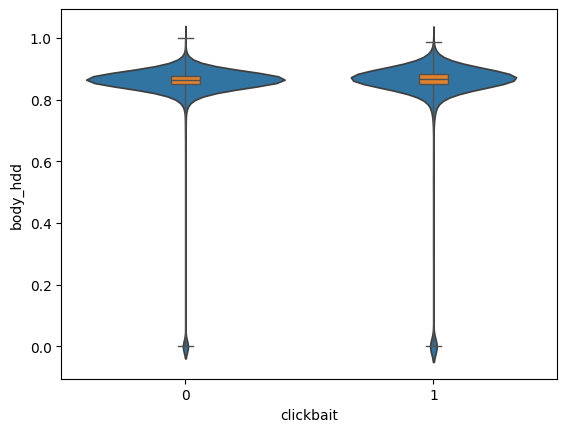

In [273]:
print_metrics(body_data, 'body_hdd', round_val=2)
plot_metrics(body_data, 'body_hdd')

In [ ]:
# all the metrics, including HDD, show that there are no differences in lexical diversity between texts with clickbait headlines and text with nonclickbait headlines

##### FRES

                 mean    std      min    50%     max  ratio
-------------  ------  -----  -------  -----  ------  -------
non clickbait   60.65  12.86  -322.01  60.85  105.66
clickbait       63.36  19.74  -710.91  63.7   119.19  1.04


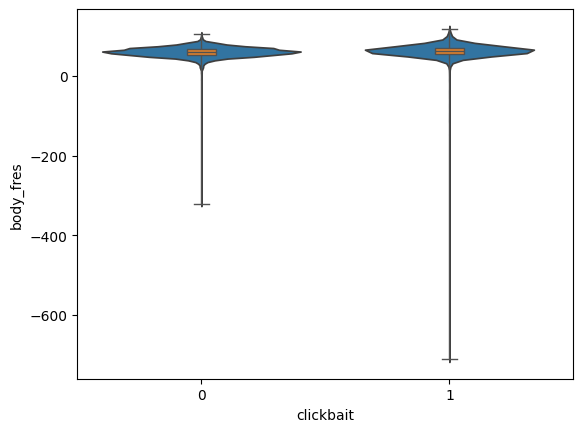

In [274]:
print_metrics(body_data, 'body_fres', round_val=2)
plot_metrics(body_data, 'body_fres')

In [ ]:
# clickbaits just a little bit easier to read. there are some outliers because of the fact that some articles are super short. 

##### FKGL

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    9.76   3.16    0.5    9.6  156.5
clickbait        9.19   3.94   -2.7    9.1  113.4  0.94


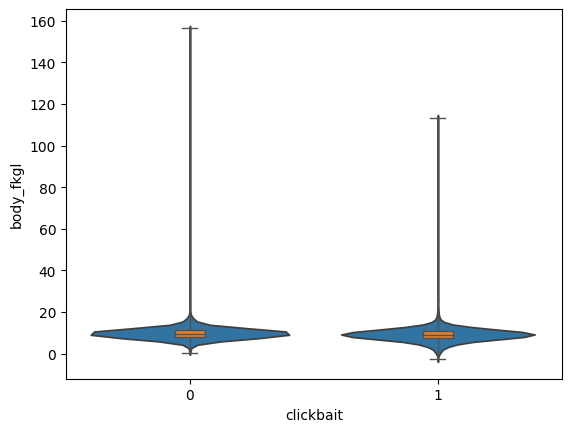

In [275]:
print_metrics(body_data, 'body_fkgl', round_val=2)
plot_metrics(body_data, 'body_fkgl')

In [ ]:
# again, clickbaits just a little bit easier to read.

##### ARI

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   12.37   4.02    2.5  12.25  201.6
clickbait       11.81   5.82   -0.8  11.6   210.2  0.95


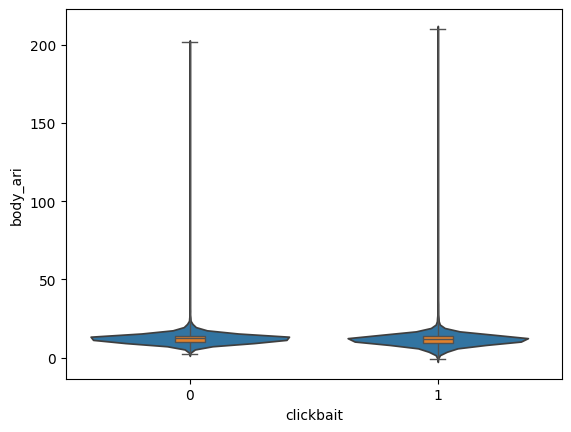

In [276]:
print_metrics(body_data, 'body_ari', round_val=2)
plot_metrics(body_data, 'body_ari')

In [ ]:
# once again, clickbaits slightly easier to read. each text difficulty measure output showed the same, so we can assume that it is true and clickbait articles on average are easier to read.

#### Summary

Relationships between measures and clickbaits are similar as in the headlines, but the differences are weaker and less visible than in the headlines. The only thing is the punctuation - in article bodies it does not differ much.

#### Fitting models

<Axes: >

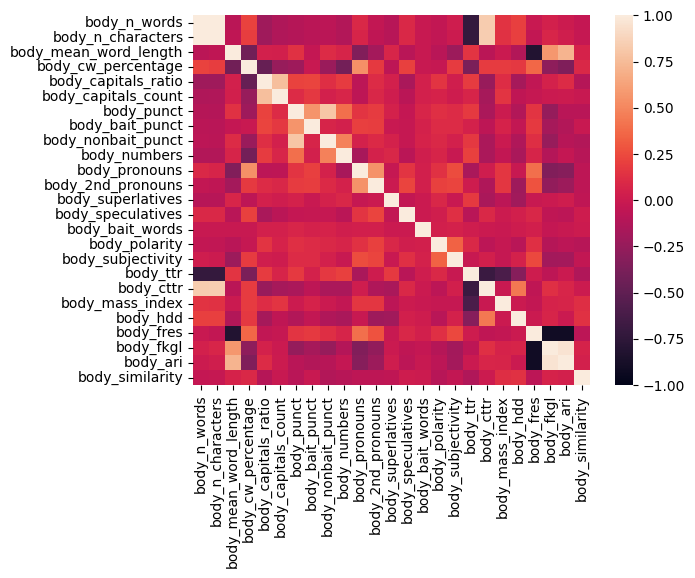

In [277]:
# check corelation
X = body_data[body_columns]
y = body_data['clickbait']

sns.heatmap(X.corr(), annot=False, vmax=1, vmin=-1)

<Axes: >

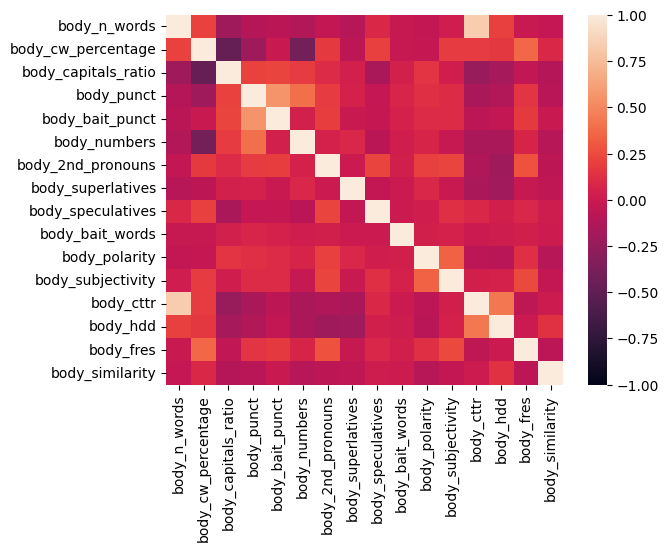

In [278]:
# dropping correlated columns
body_cols_to_drop = ['body_n_characters', 'body_mean_word_length', 'body_capitals_count', 'body_nonbait_punct', 'body_pronouns', 'body_ttr', 'body_mass_index', 'body_fkgl', 'body_ari']
body_columns_dropped = [col for col in body_columns if col not in body_cols_to_drop]

X = body_data[body_columns_dropped]
y = body_data['clickbait']

sns.heatmap(X.corr(), annot=False, vmax=1, vmin=-1)

In [ ]:
# from title analysis
train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']

In [280]:
X = body_data[train_columns + body_columns_dropped]
y = body_data['clickbait']

X_test = body_test_data[train_columns + body_columns_dropped]
y_test = body_test_data['clickbait']

In [281]:
X_train = X
y_train = y

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [282]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.598308
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14864
Method:                           MLE   Df Model:                           29
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1368
Time:                        15:14:34   Log-Likelihood:                -8911.2
converged:                       True   LL-Null:                       -10324.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
n_words                 0.0025      0.029      0.084      0.933      -0.055       0.060
cw

In [284]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.45 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      1810
           1       0.68      0.68      0.68      1792

    accuracy                           0.68      3602
   macro avg       0.68      0.68      0.68      3602
weighted avg       0.68      0.68      0.68      3602



There is also big corelation between only n_words and ttr, so lets drop one and fit a model again

In [285]:
cols_to_drop = ['capitals_count', 'speculatives', 'polarity', 'mass_index', 'body_speculatives', 'body_superlatives', 'body_hdd', 'body_bait_words']

X_train = X.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test2)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.599870
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14894
Model:                          Logit   Df Residuals:                    14872
Method:                           MLE   Df Model:                           21
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1346
Time:                        15:15:42   Log-Likelihood:                -8934.5
converged:                       True   LL-Null:                       -10324.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
n_words                -0.0440      0.025     -1.728      0.084      -0.094       0.006
cw

In [287]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.45 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1810
           1       0.68      0.68      0.68      1792

    accuracy                           0.68      3602
   macro avg       0.68      0.68      0.68      3602
weighted avg       0.68      0.68      0.68      3602



Out metrics did not get slightly better, but atleast our model is smaller.

Lets try to fit random forest with all the variables:

In [288]:
# from title analysis
# train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']

X_train = body_data[train_columns + body_columns_dropped]
y_train = body_data['clickbait']

X_test = body_test_data[train_columns + body_columns_dropped]
y_test = body_test_data['clickbait']

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1810
           1       0.71      0.70      0.71      1792

    accuracy                           0.71      3602
   macro avg       0.71      0.71      0.71      3602
weighted avg       0.71      0.71      0.71      3602



And with little bit of manual fine tuning:

In [ ]:
cols_to_drop = ['capitals_count', 'speculatives', 'polarity', 'mass_index', 'body_speculatives', 'body_superlatives', 'body_hdd', 'body_bait_words']

X_train2 = X_train.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

rf = RandomForestClassifier(n_estimators=120, max_depth=15)
rf.fit(X_train2, y_train)

threshold = 0.49
predicted_proba = rf.predict_proba(X_test2)
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1810
           1       0.72      0.71      0.71      1792

    accuracy                           0.72      3602
   macro avg       0.72      0.72      0.72      3602
weighted avg       0.72      0.72      0.72      3602



In [ ]:
# It shows that information about the article itself is a value added in clickbait classification task. It gave us 9% better accuracy and f-score (0.66 vs 0.72)

In [292]:
pd.DataFrame(data={'feature': rf.feature_names_in_, 'importance': rf.feature_importances_}, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
12,body_capitals_ratio,0.093591
1,cw_percentage,0.079776
16,body_2nd_pronouns,0.076238
18,body_subjectivity,0.056537
21,body_similarity,0.056449
19,body_cttr,0.052890
10,body_n_words,0.052447
2,capitals_ratio,0.052370
14,body_bait_punct,0.049489
17,body_polarity,0.048434


##### Grid search fine tuning

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features':  ['sqrt', 'log2']
}

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train2, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, n_estimators=120),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]})

In [ ]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
best_params

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 200}

In [126]:
threshold = 0.48
predicted_proba = best_rf.predict_proba(X_test2)
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2006
           1       0.72      0.76      0.74      1982

    accuracy                           0.74      3988
   macro avg       0.74      0.74      0.74      3988
weighted avg       0.74      0.74      0.74      3988



## Our measure

### Definition

In [ ]:
"""
eye catchingness
special punctuation - yes / no
capitals
number s

curiosity generating techniques
2nd person pronoun - yes / no
superlatives - yes / no
bait vocabulary - yes / no

sqrt common words 

average of usages 

sentiment
sqrt() for each and then multiply
"""

'\neye catchingness\nspecial punctuation - yes / no\nonly capital letters word\nsqrt capitals\nnumber \n\ncuriosity generating techniques\n2nd person pronoun - yes / no\nsuperlatives - yes / no\nbait vocabulary - yes / no\n\nsqrt common words \n\naverage of usages \n\nsentiment\nsqrt() for each and then multiply\n'

In [295]:
def cut_value(value):
    if value > 1:
        return 1
    elif value < 0:
        return 0
    return value

In [ ]:
def baitness_measure(text, debug=False):

    # eye catchingness
    punct_count = clickbait_punctuation_count(text)
    capitals_ratio = capital_letters_ratio(text) * 3
    number_count = numbers_count(text)

    eye_catch_list = [punct_count, capitals_ratio, number_count]
    eye_catch = cut_value(np.mean(eye_catch_list))
    if debug:
        print(eye_catch_list)
    
    # content curiosity
    pronouns_2_count = pronouns_2nd_person_count(text)
    super_count = superlatives_ratio(text) * 2
    spec_count = speculatives_count(text)
    bait_words = baiting_words_count(text)

    curiosity_list = [pronouns_2_count, super_count, spec_count, bait_words]
    curiosity = np.sqrt(cut_value(np.mean(curiosity_list)))
    if debug:
        print(curiosity_list)

    # sentiment - measures high polarity and high subjectivity
    sentiment = math.sqrt(abs(polarity_score(text)) * subjectivity_score(text))

    # difficulty of reading - reading ease score and common words ratio
    fres = cut_value(flesch_reading_ease_score(text) / 100)
    cw_ratio = cut_value(common_words_ratio(text) * 1.5)
    ease_of_text = np.mean([fres, cw_ratio])

    metric_list = [eye_catch, sentiment, ease_of_text, curiosity]
    measure = np.mean(metric_list)
    if debug:
        print(metric_list)
    
    return measure

#### small tests

In [297]:
baitness_measure(sample_text[:66], debug=True)

[1, 0.4545454545454546, 0, 1]
[1, 0.6666666666666666, 0, 0]
[0.6136363636363636, 0.35355339059327373, 0.6165772727272727, 0.6454972243679028]


0.5573160628312032

In [298]:
baitness_measure("Daniel Kaluuya: 'In Britain I’m too black, in America I'm not black enough'", debug=True)

[0, 0.28, 0, 0]
[0, 0.0, 0, 0]
[0.07, 0.11249142628509215, 0.7606, 0.0]


0.23577285657127306

### Testing

In [391]:
custom_data = test_data.copy()
custom_data['measure'] = custom_data['title'].apply(baitness_measure)

In [392]:
print_metrics(custom_data, column="measure")

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.22   0.11   0      0.2    0.69
clickbait        0.37   0.15   0.02   0.38   0.95  1.68


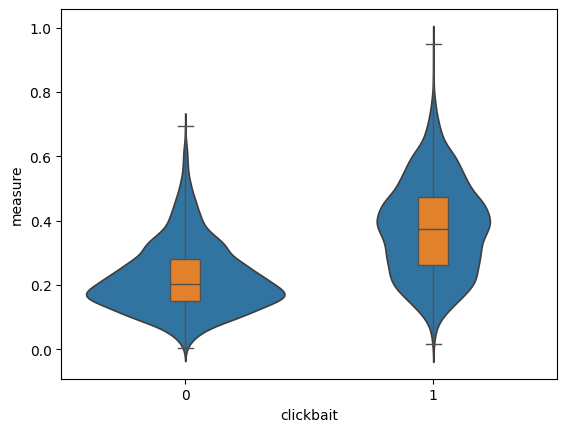

In [393]:
plot_metrics(custom_data, column="measure")

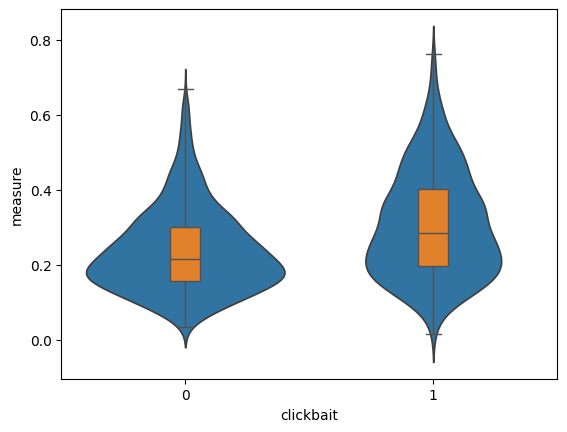

In [394]:
# distribution only for cc dataset
plot_metrics(custom_data[custom_data['set']==3], column="measure")

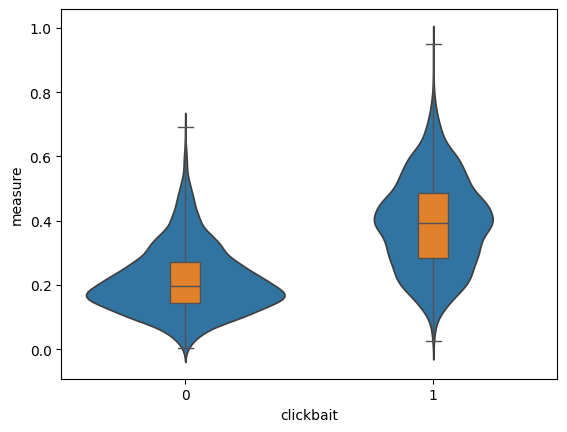

In [395]:
# distribution for kaggle datasets
plot_metrics(custom_data[custom_data['set']!=3], column="measure")

In [ ]:
# it can be seen that the 

In [396]:
custom_data['measure_sqrt'] = custom_data['measure'].apply(math.sqrt)

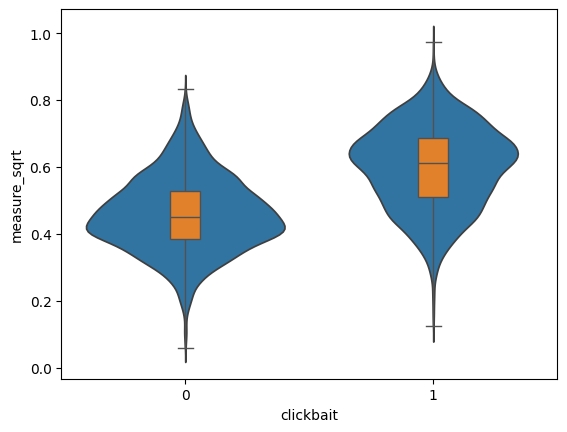

In [397]:
plot_metrics(custom_data, column="measure_sqrt")

In [308]:
custom_data[custom_data['measure'] > 0.6][custom_data['clickbait'] == 0]

/tmp/ipykernel_1266/1950810332.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_data[custom_data['measure'] > 0.6][custom_data['clickbait'] == 0]


,title,clickbait,set,measure,measure_sqrt
4984,"What You Need to Know About the MOAB, the Powe...",0,2,0.638008,0.798754
2678,'How do you explain your Twitter?': Senator gr...,0,2,0.614426,0.783854
13400,"ABC News auf Twitter: ""POTUS on Russian interf...",0,2,0.621933,0.788627
4496,KPMGVoice: Is Your IT Staff Being Used the Rig...,0,3,0.610048,0.781056
6373,Can Slings and Arrows Lead to an Outrageous Fo...,0,3,0.641543,0.800964
...,...,...,...,...,...
7287,Hate Doing Laundry? This Is the Robot for You,0,3,0.669161,0.818023
1759,The Spin’s best Test cricket XI of 2016,0,2,0.643996,0.802493
11637,Does Lorde Have the Best 'Green Light'? Vote f...,0,2,0.651436,0.807116
19963,The 50 Best Podcasts of 2016,0,2,0.645334,0.803327


In [307]:
custom_data[custom_data['measure'] < 0.4][custom_data['clickbait'] == 1]

/tmp/ipykernel_1266/2731889863.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  custom_data[custom_data['measure'] < 0.4][custom_data['clickbait'] == 1]


,title,clickbait,set,measure,measure_sqrt
24990,Ann Coulter: Obama Should Testify Under Oath o...,1,3,0.140949,0.375432
30334,This Photo Series Shows How Instagram Photos O...,1,1,0.307781,0.554780
26175,21 Questions Every Single Person In L.A. Has A...,1,1,0.336492,0.580079
26847,Here's How To Make The Only Birthday Cake You'...,1,1,0.335855,0.579530
25194,How we could close tech’s gender gap in a decade,1,3,0.332031,0.576222
...,...,...,...,...,...
31551,Here's Why #DuragHistoryWeek Is Important,1,1,0.368326,0.606899
35773,Which Gangster Movie Bride Are You,1,1,0.375876,0.613087
27480,Which Shia LaBeouf GIF Matches Your Zodiac Sign,1,1,0.378608,0.615311
39188,Here's The Feminist Advice Lucille Ball Gave T...,1,1,0.144900,0.380658


### Classification

In [402]:
threshold = 0.27

preds = (custom_data['measure'].to_numpy() >= threshold).astype('int')

print(classification_report(custom_data['clickbait'], preds))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      4014
           1       0.72      0.74      0.73      3986

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



In [ ]:
# kaggle datasets only
threshold = 0.28

preds = (custom_data[custom_data['set']!=3]['measure'].to_numpy() >= threshold).astype('int')

print(classification_report(custom_data[custom_data['set']!=3]['clickbait'], preds))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2664
           1       0.80      0.76      0.78      3207

    accuracy                           0.77      5871
   macro avg       0.77      0.77      0.77      5871
weighted avg       0.77      0.77      0.77      5871



In [ ]:
# cc dataset only
threshold = 0.28

preds = (custom_data[custom_data['set']==3]['measure'].to_numpy() >= threshold).astype('int')

print(classification_report(custom_data[custom_data['set']==3]['clickbait'], preds))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1350
           1       0.50      0.51      0.51       779

    accuracy                           0.63      2129
   macro avg       0.61      0.61      0.61      2129
weighted avg       0.64      0.63      0.63      2129



In [ ]:
# in the cc dataset it is not that easy to distinguish clickbait from non clickbait